gerekli olan kütüphaneler eklenir
torchviz
tourch-summary
yfinance
numpy 
pandas
tqdm


In [607]:
import torch
import numpy as np
import pandas as pd 
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim 
import torch.nn.functional as f
from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
# from keras.utils import plot_model
from keras.src.utils.model_visualization import plot_model
from keras.src.models.sequential import Sequential
# from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"



In [608]:
# tck = yf.Ticker("KCHOL.IS") 
# start_date = "2020-01-02"
import os
if os.path.exists("model.pth"):
    os.remove("model.pth")
symbol = "SISE.IS"
start_date = "2020-01-02"
# Hisse verilerini al
# end_date = df.index[-1].strftime('%Y-%m-%d') 
tck = yf.Ticker(symbol)
df = tck.history(start=start_date, end=None)
df.tail()

Open       High        Low      Close  \
Date                                                                    
2025-01-02 00:00:00+03:00  41.759998  41.959999  41.380001  41.680000   
2025-01-03 00:00:00+03:00  41.759998  42.560001  41.720001  42.540001   
2025-01-06 00:00:00+03:00  42.619999  43.000000  41.520000  42.139999   
2025-01-07 00:00:00+03:00  42.160000  42.619999  41.860001  41.880001   
2025-01-08 00:00:00+03:00  41.900002  42.119999  41.639999  41.820000   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-01-02 00:00:00+03:00  40016000        0.0           0.0  
2025-01-03 00:00:00+03:00  38835776        0.0           0.0  
2025-01-06 00:00:00+03:00  42872412        0.0           0.0  
2025-01-07 00:00:00+03:00  31582376        0.0           0.0  
2025-01-08 00:00:00+03:00  10448715        0.0           0.0

In [609]:
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

Close      Open      High       Low    Volume  \
Date                                                                          
2020-01-02 00:00:00+03:00  4.828517  4.792281  4.855695  4.774163  62036079   
2020-01-03 00:00:00+03:00  4.774163  4.801340  4.855695  4.683572  62950188   
2020-01-06 00:00:00+03:00  4.638276  4.746985  4.783222  4.620157  65070398   
2020-01-07 00:00:00+03:00  4.638276  4.692630  4.701690  4.620157  39917326   
2020-01-08 00:00:00+03:00  4.611098  4.529565  4.656393  4.493329  54799214   

                           Dividends  Stock Splits  
Date                                                
2020-01-02 00:00:00+03:00        0.0           0.0  
2020-01-03 00:00:00+03:00        0.0           0.0  
2020-01-06 00:00:00+03:00        0.0           0.0  
2020-01-07 00:00:00+03:00        0.0           0.0  
2020-01-08 00:00:00+03:00        0.0           0.0

In [610]:
df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [611]:
columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

In [612]:
df.shape

(1256, 7)

In [613]:
def check_df(df: object, head: object = 5) -> object:
    print("\nShape")
    print(df.shape)
    print("\nTypes")
    print(df.dtypes)
    print("\nNANs")
    print(df.isnull().sum())
    print("\nInfo")
    print(df.info())
check_df(df)


Shape
(1256, 7)

Types
Close           float64
Open            float64
High            float64
Low             float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

NANs
Close           0
Open            0
High            0
Low             0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1256 entries, 2020-01-02 00:00:00+03:00 to 2025-01-08 00:00:00+03:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1256 non-null   float64
 1   Open          1256 non-null   float64
 2   High          1256 non-null   float64
 3   Low           1256 non-null   float64
 4   Volume        1256 non-null   int64  
 5   Dividends     1256 non-null   float64
 6   Stock Splits  1256 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.5 KB
None


In [614]:
df['Volume'] = df['Volume'].astype('float64') #hacim int->float

In [615]:
print('Number of duplicated rows: ' , len(df[df.duplicated()])) #tekrar eden satırlar

Number of duplicated rows:  0


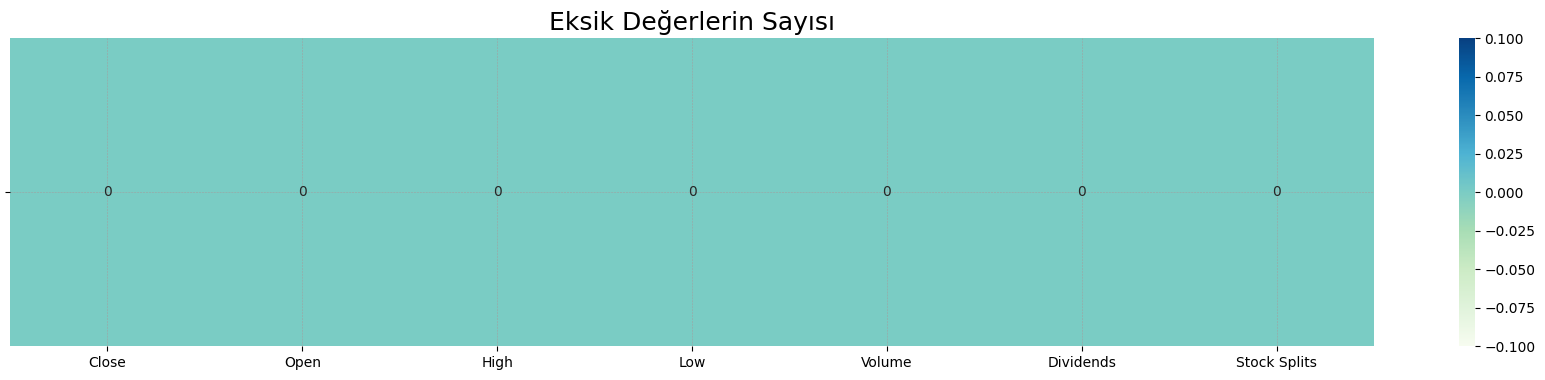

In [616]:
plt.figure(figsize=(22,4))
sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='GnBu', annot=True,
             fmt='0.0f').set_title('Eksik Değerlerin Sayısı', fontsize=18)
plt.show()

In [617]:
df.describe().T.style.background_gradient(cmap='GnBu', axis=1)

In [618]:
# benzersiz veriler bulma
df.apply(lambda x: len(x.unique()))

Close            983
Open            1227
High            1221
Low             1212
Volume          1256
Dividends          6
Stock Splits       1
dtype: int64

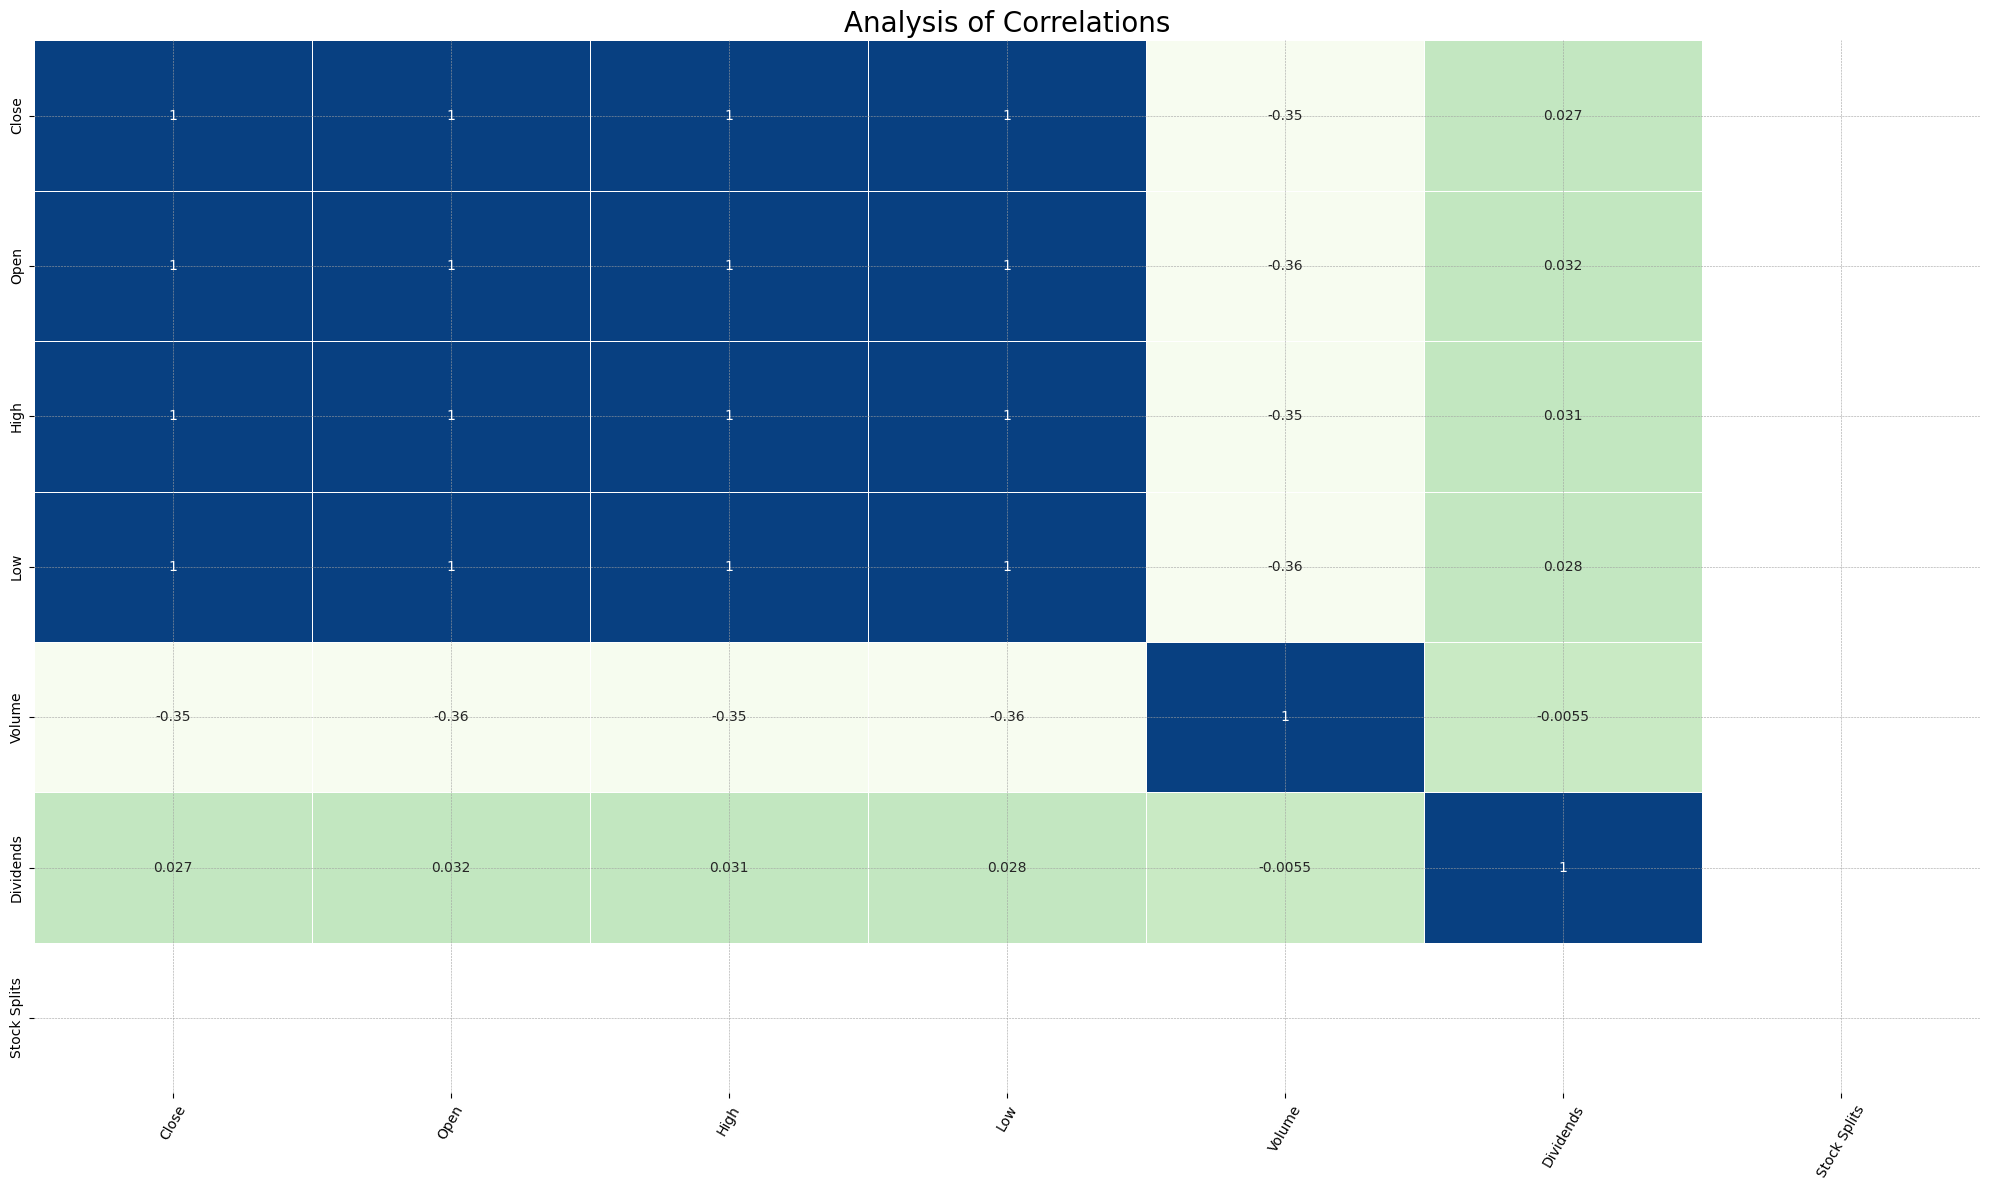

In [619]:
plt.figure(figsize=(20, 12))
sns.heatmap(df.corr(numeric_only=True), cmap="GnBu", annot=True, linewidths=.6 , cbar = False)
plt.xticks(rotation=60, size=10)
plt.yticks(size=10)
plt.title('Analysis of Correlations', size=20)
plt.tight_layout()
plt.show()#temettü ve bölünme olmadığı için boş thyaoda

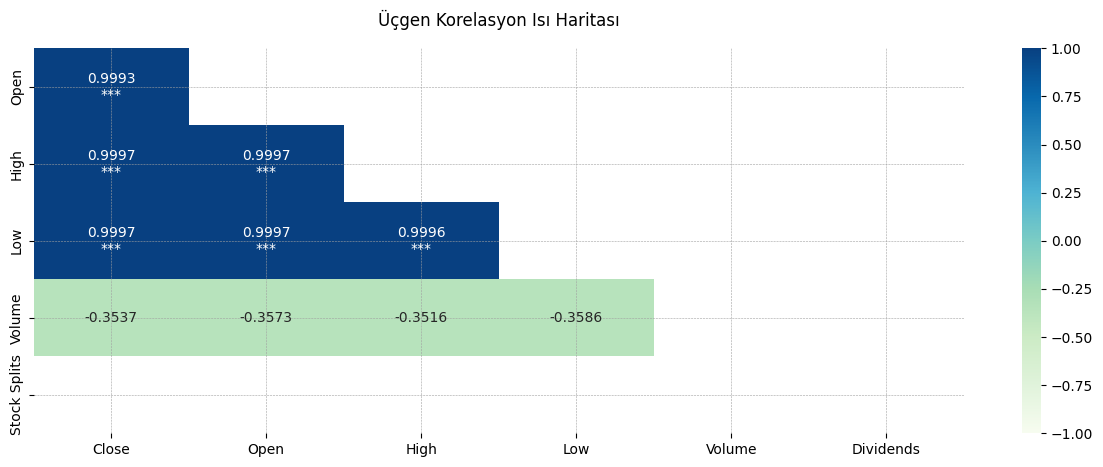

In [620]:
corr = df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(15, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
cut_off = 0.25
extreme_1 = 0.5
extreme_2 = 0.75
extreme_3 = 0.9
mask |= np.abs(corr) < cut_off
corr = corr[~mask]
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]

annot = [[f"{val:.4f}"
          + ('' if abs(val) < extreme_1 else '\n*')
          + ('' if abs(val) < extreme_2 else '*')
          + ('' if abs(val) < extreme_3 else '*')
          for val in row] for row in corr.to_numpy()]
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=annot, fmt='', cmap='GnBu')
heatmap.set_title('Üçgen Korelasyon Isı Haritası', fontdict={'fontsize': 12}, pad=16)
plt.show()

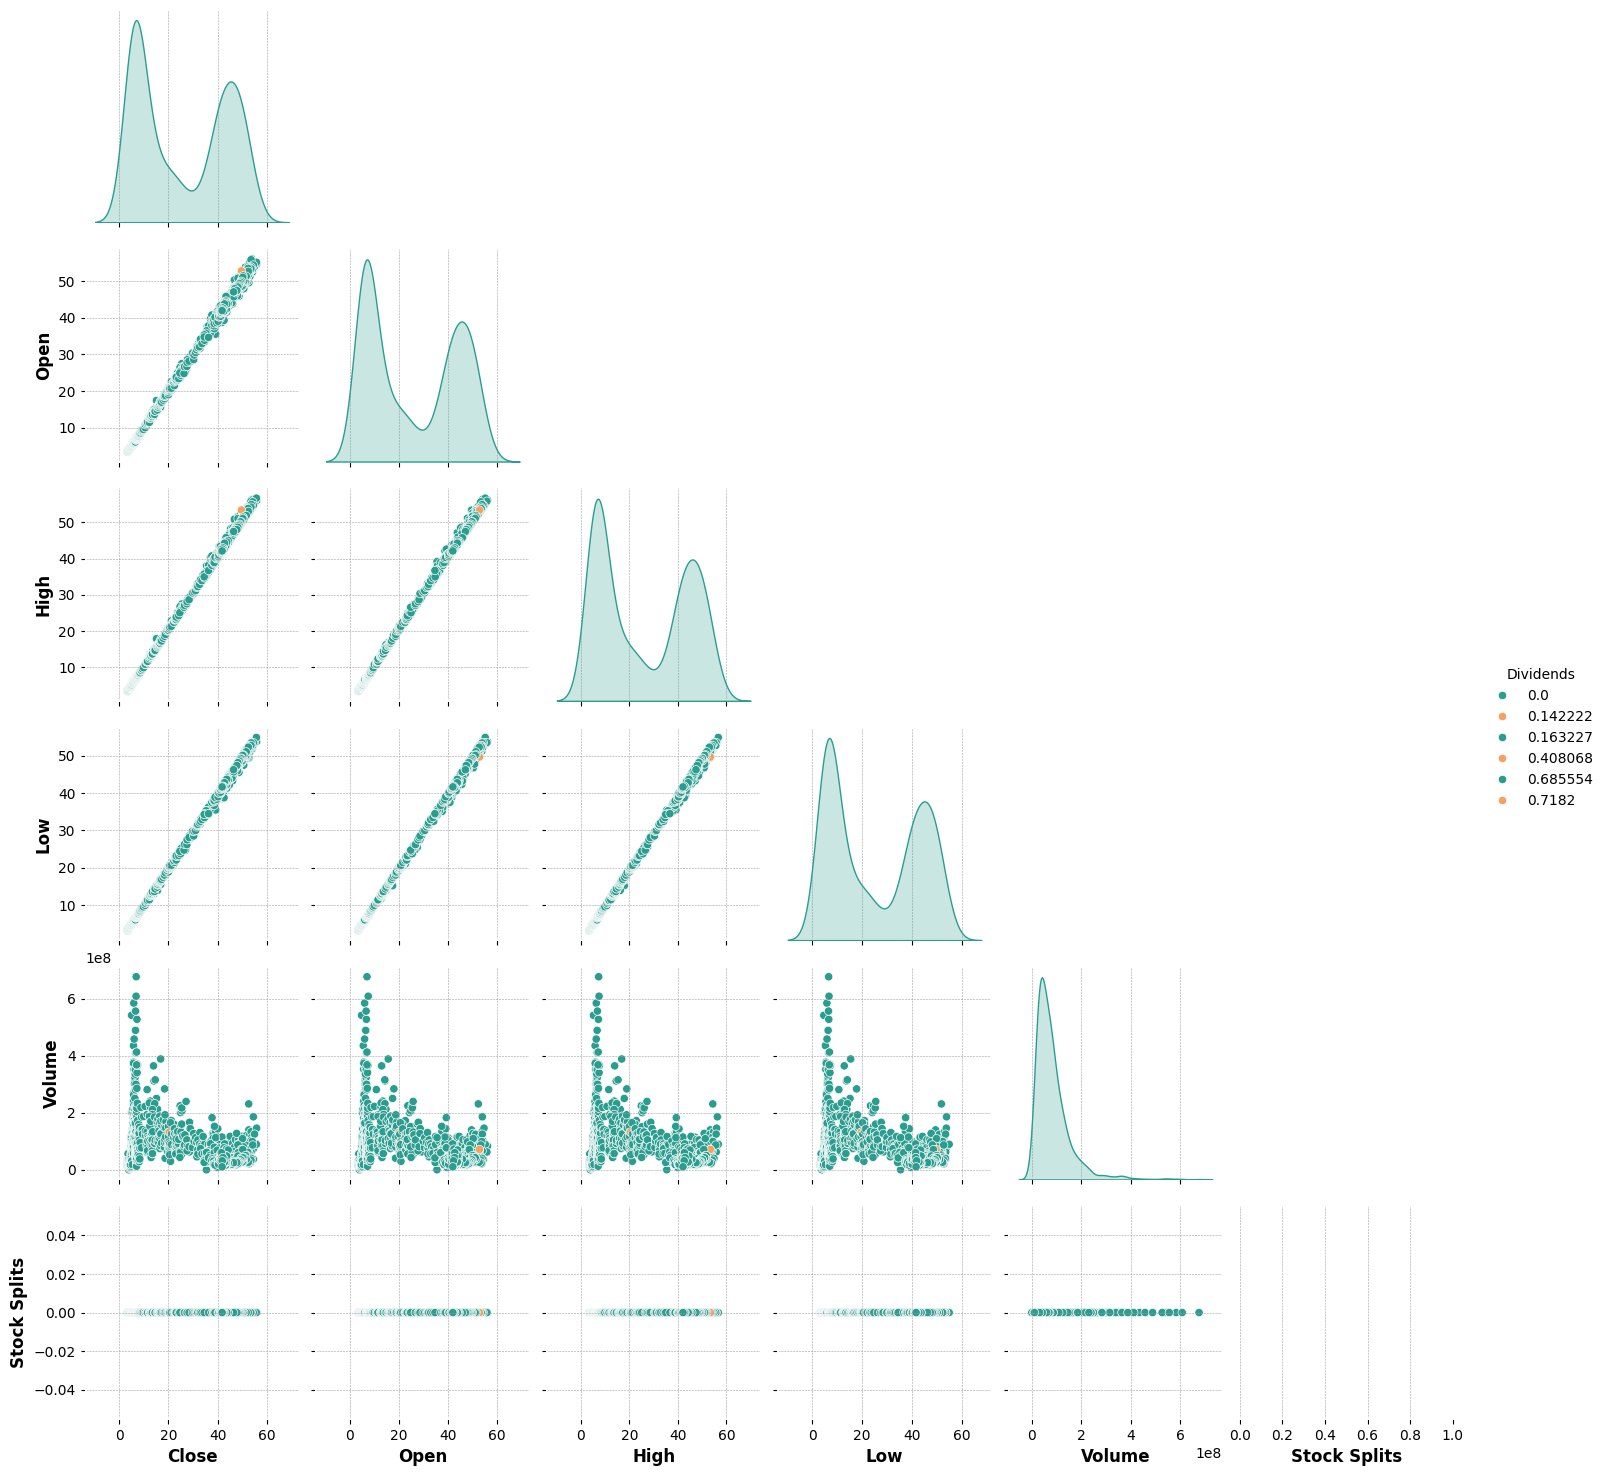

In [621]:
import warnings
warnings.filterwarnings('ignore')
custom_palette = sns.color_palette(['#2a9d8f', '#f4a261'])
sns.pairplot(data=df, diag_kind='kde', hue='Dividends', palette=custom_palette,corner=True)
plt.gcf().set_facecolor('#ffffff')
plt.show()

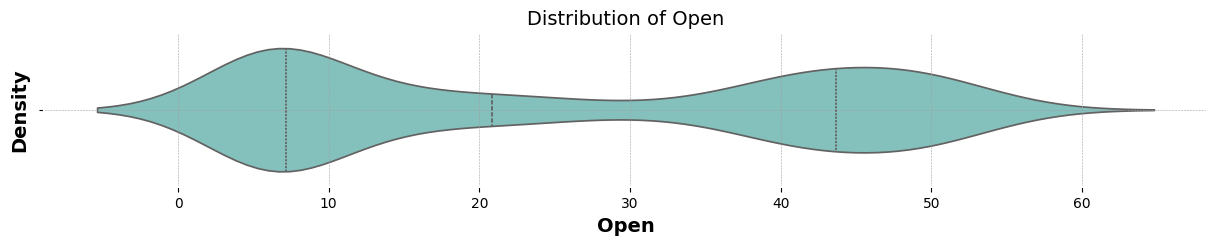

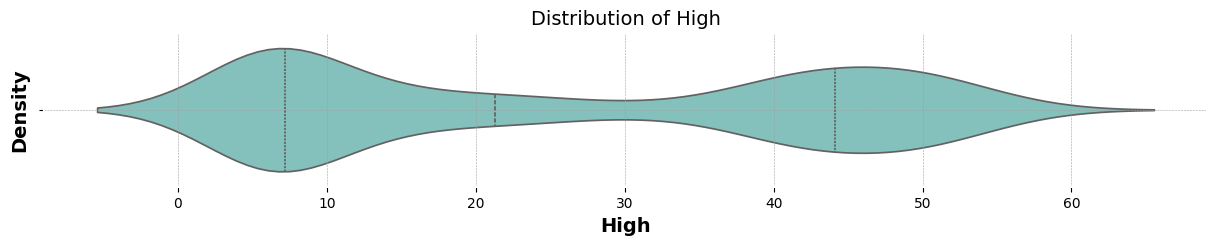

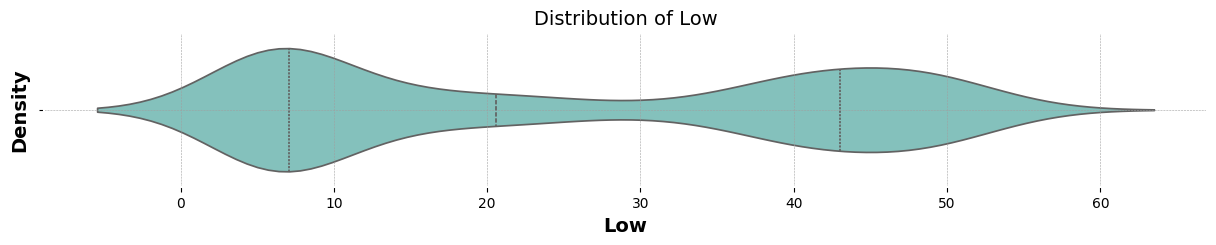

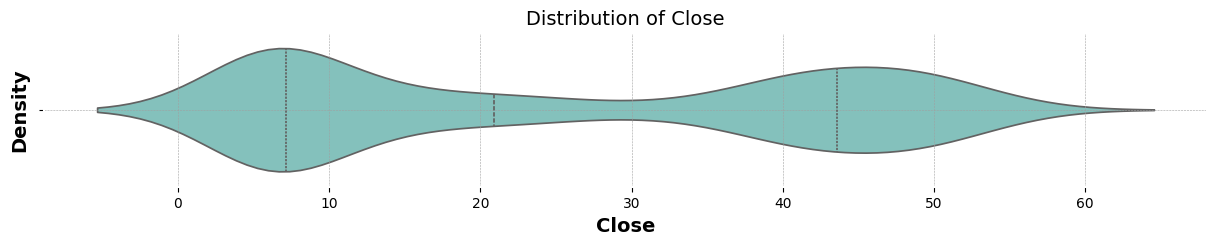

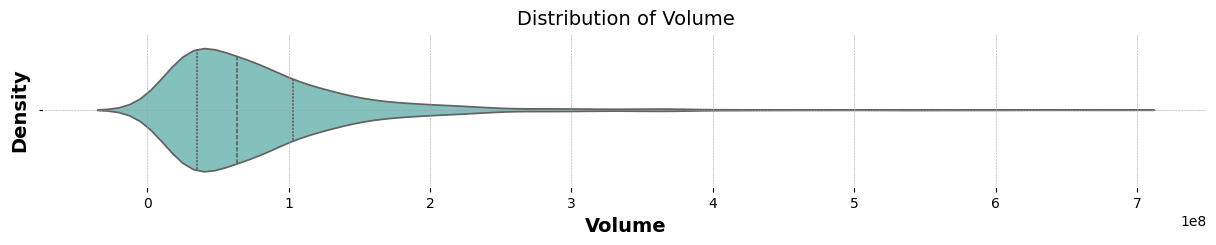

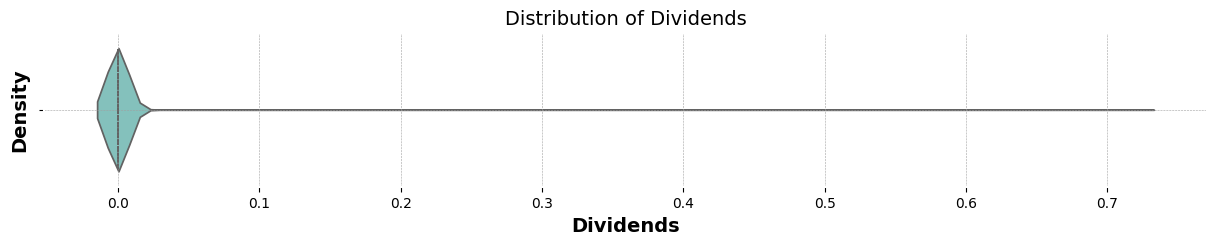

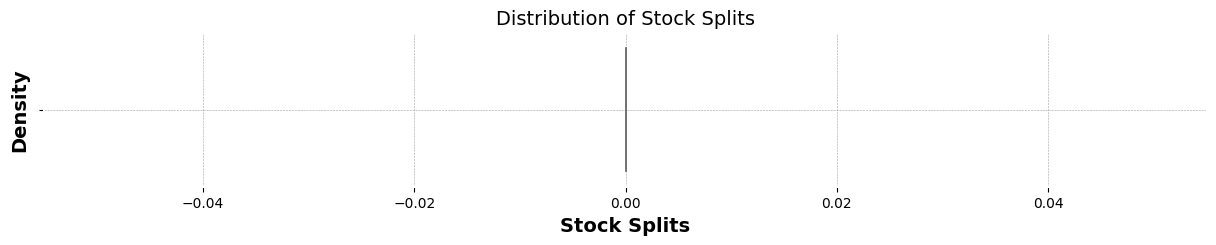

In [622]:
palette = "GnBu"
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.violinplot(x=df[column], palette=palette, inner="quartile")  
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True)
    plt.show()

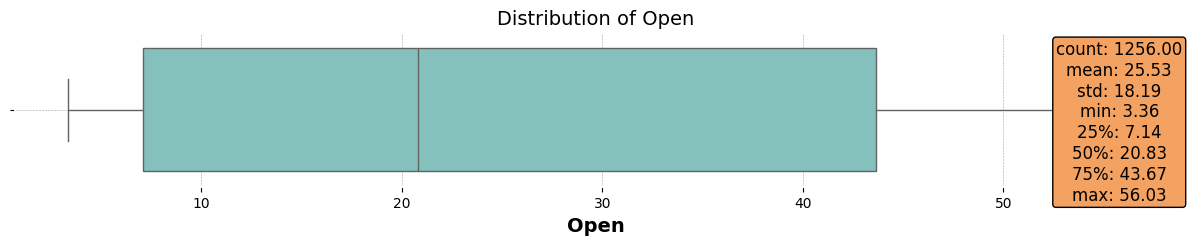

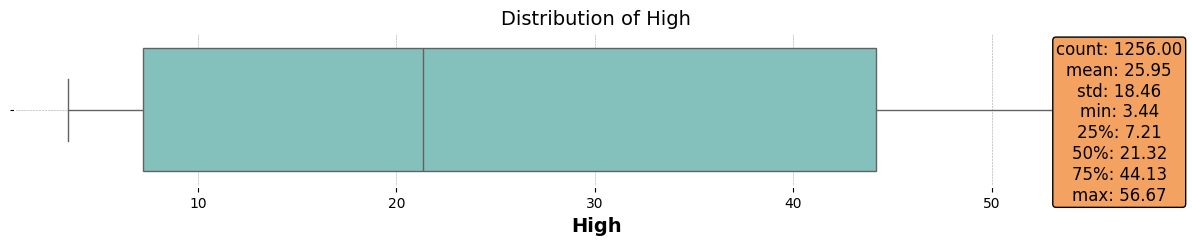

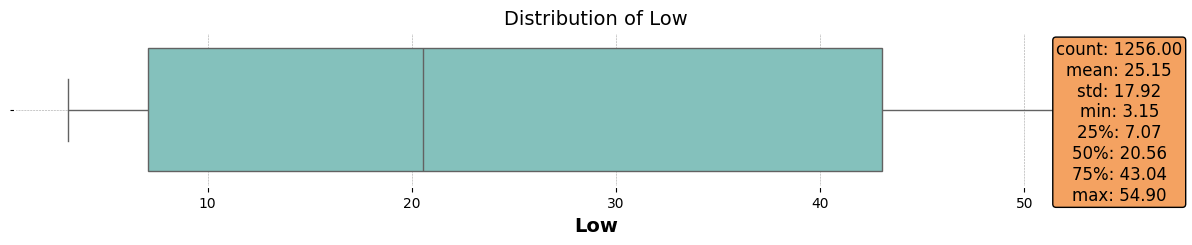

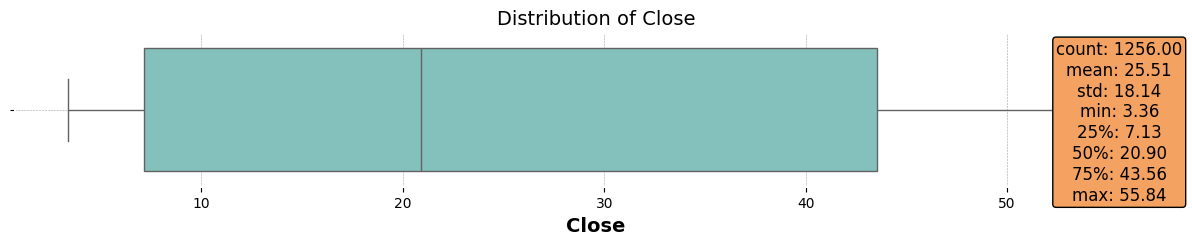

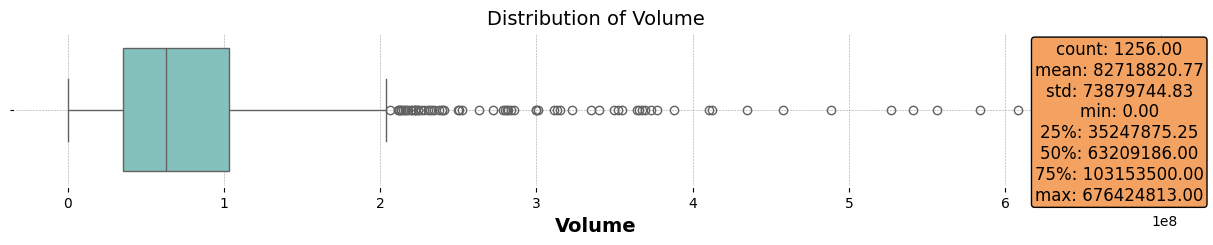

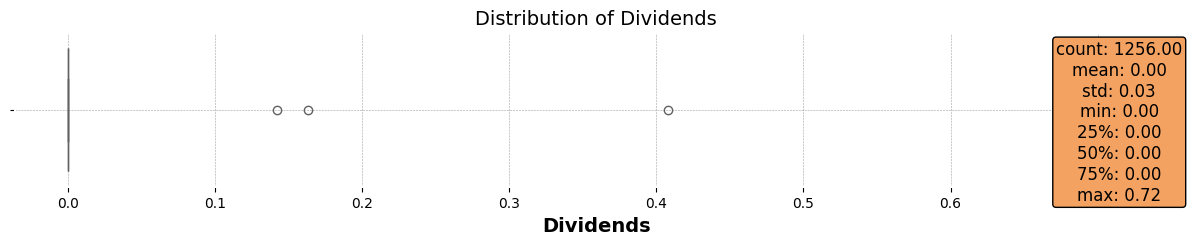

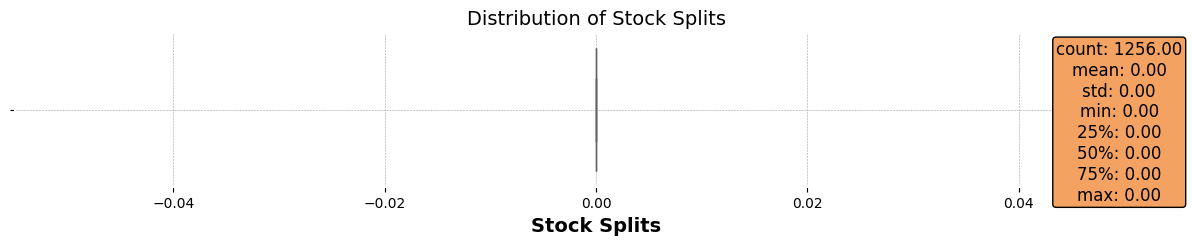

In [623]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(15, 2)) 
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=14)
    stats = df[column].describe()
    stats_text = "\n".join([f"{key}: {value:.2f}" for key, value in stats.items()])
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', 
             horizontalalignment='center', bbox=dict(boxstyle='round,pad=0.2', edgecolor='black', facecolor='#f4a261'))
    plt.grid(True) 
    plt.show()

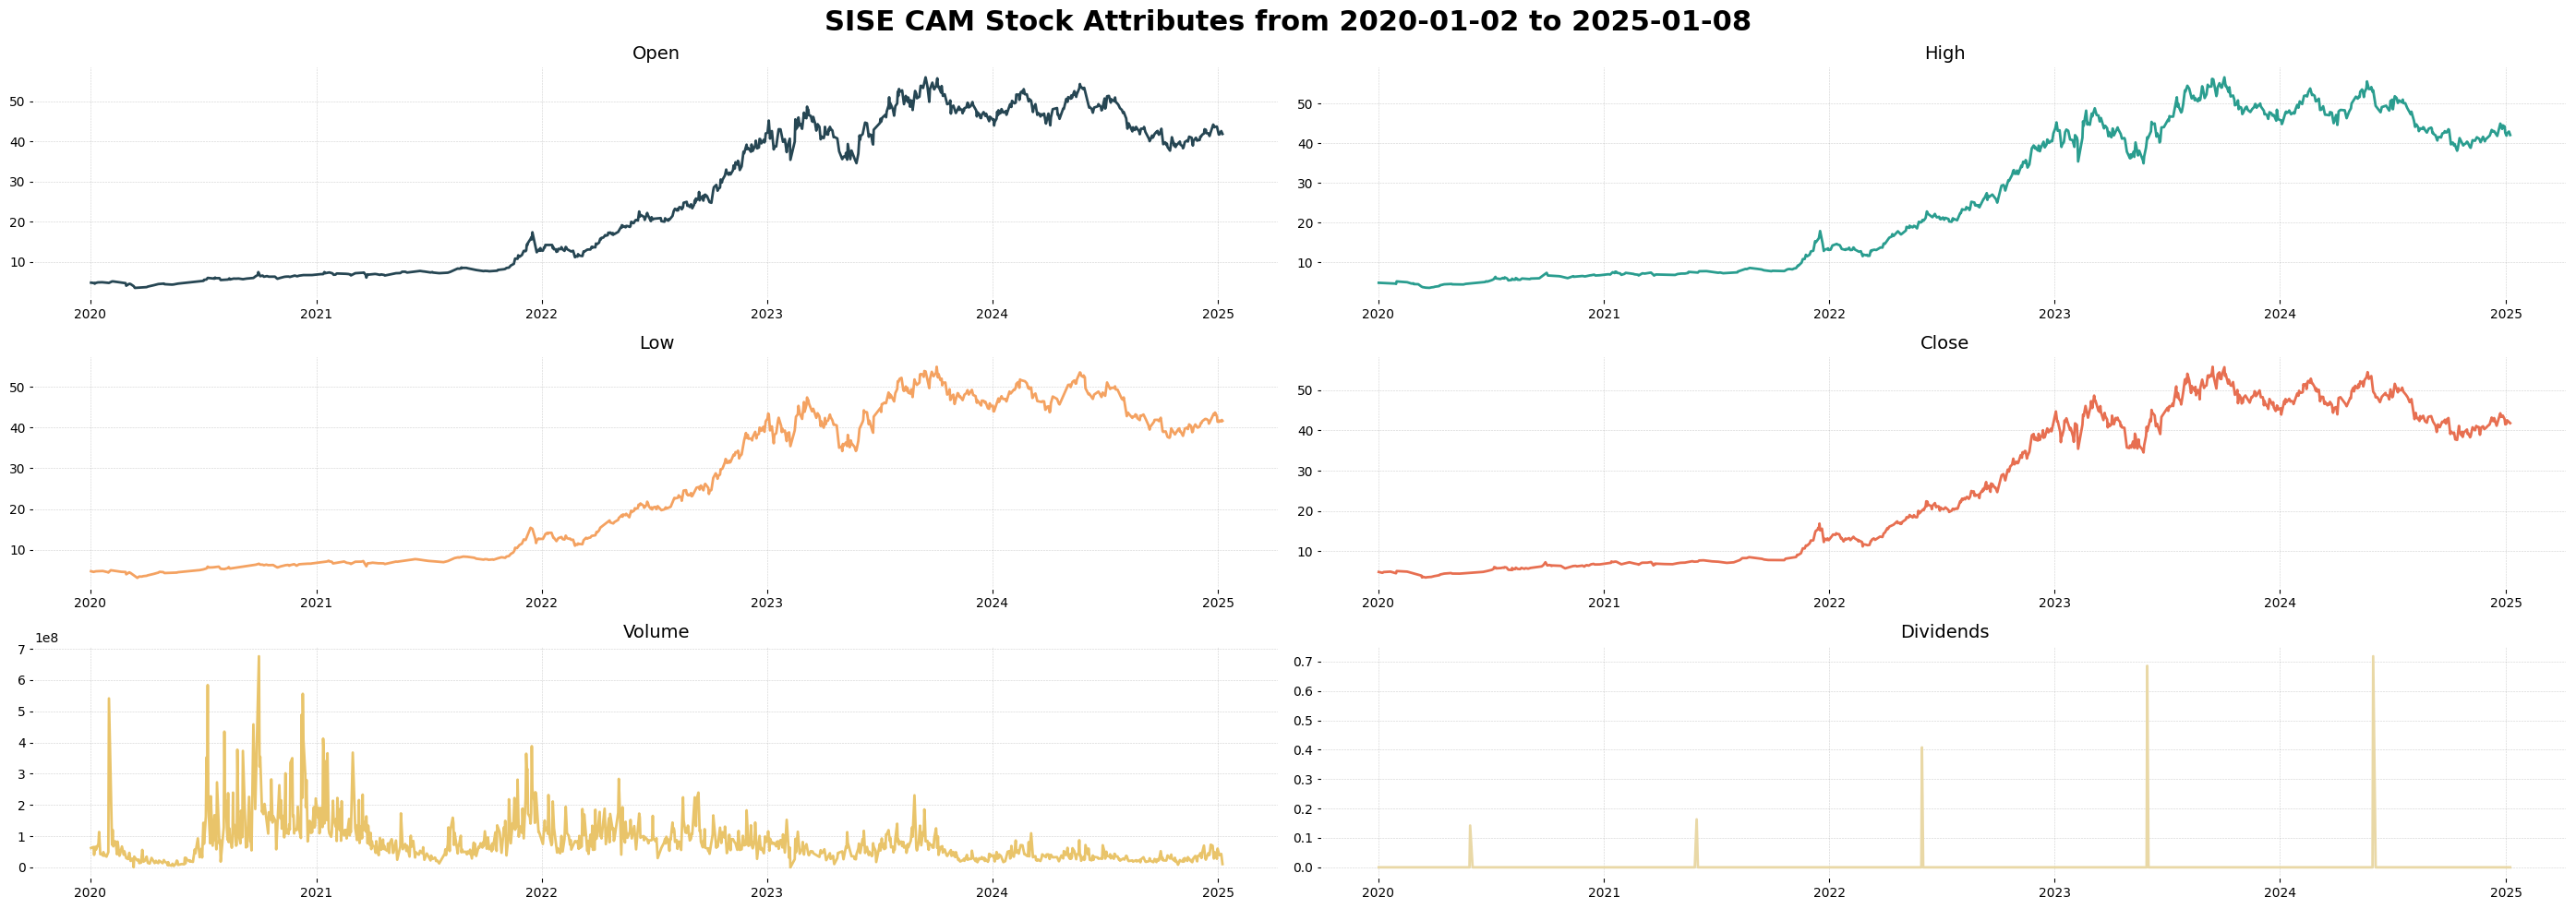

In [624]:
import matplotlib.pyplot as plt
x=df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28, 10))
plt.subplot(3, 2, 1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 2)
plt.plot(x, df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.plot(x, df['Dividends'], color=colors[5], linewidth=2)
plt.title('Dividends', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
end_date = df.index[-1].strftime('%Y-%m-%d')  # Verisetindeki son tarihi al
plt.suptitle(f'{tck.info["shortName"]} Stock Attributes from {start_date} to {end_date}', fontsize=22, y=0.98)
plt.tight_layout()
plt.show()

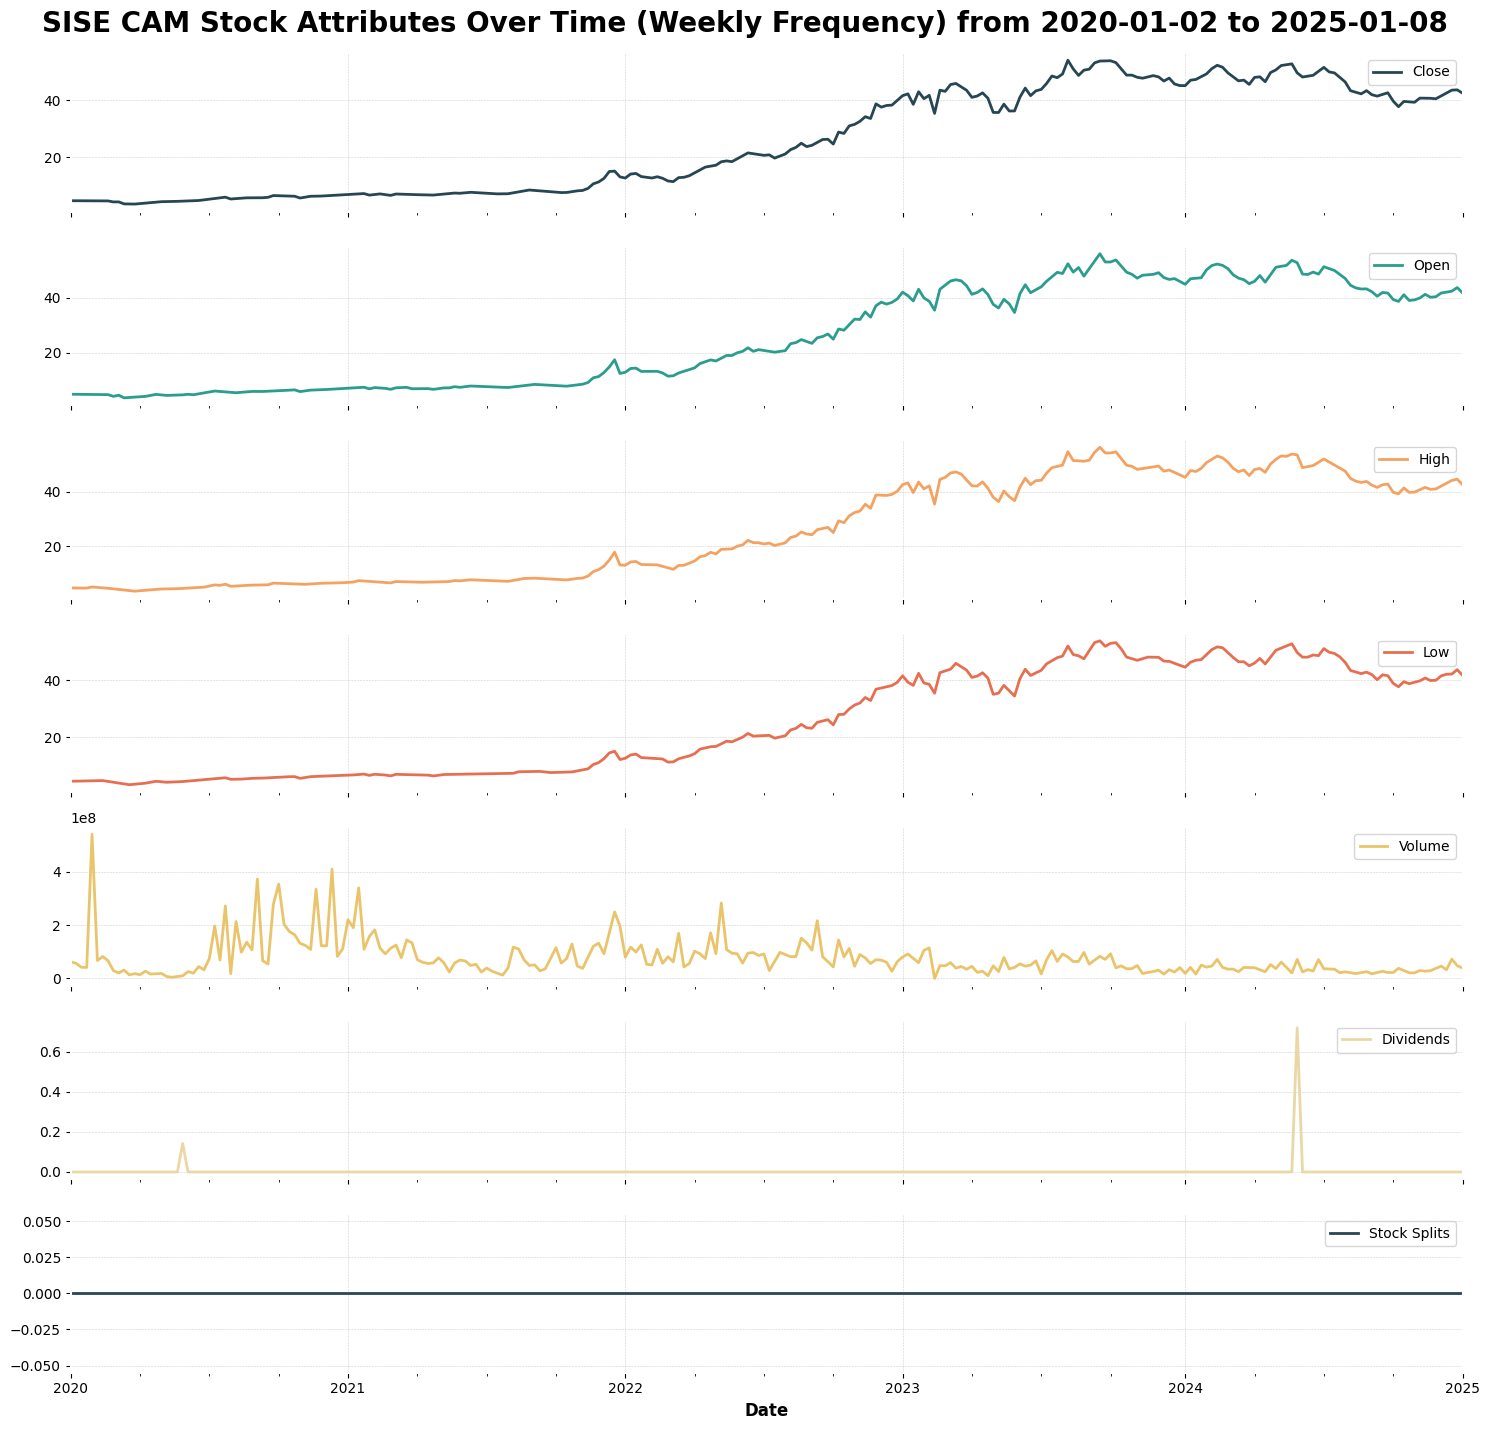

In [625]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']
df_weekly = df.asfreq('W', method='ffill')
df_weekly.plot(subplots=True, figsize=(15, 15), style='-', color=colors, linewidth=2)
end_date = df.index[-1].strftime('%Y-%m-%d')  # Verisetindeki son tarihi al
plt.suptitle(f'{tck.info["shortName"]} Stock Attributes Over Time (Weekly Frequency) from {start_date} to {end_date}', fontsize=20, y=0.95)
for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

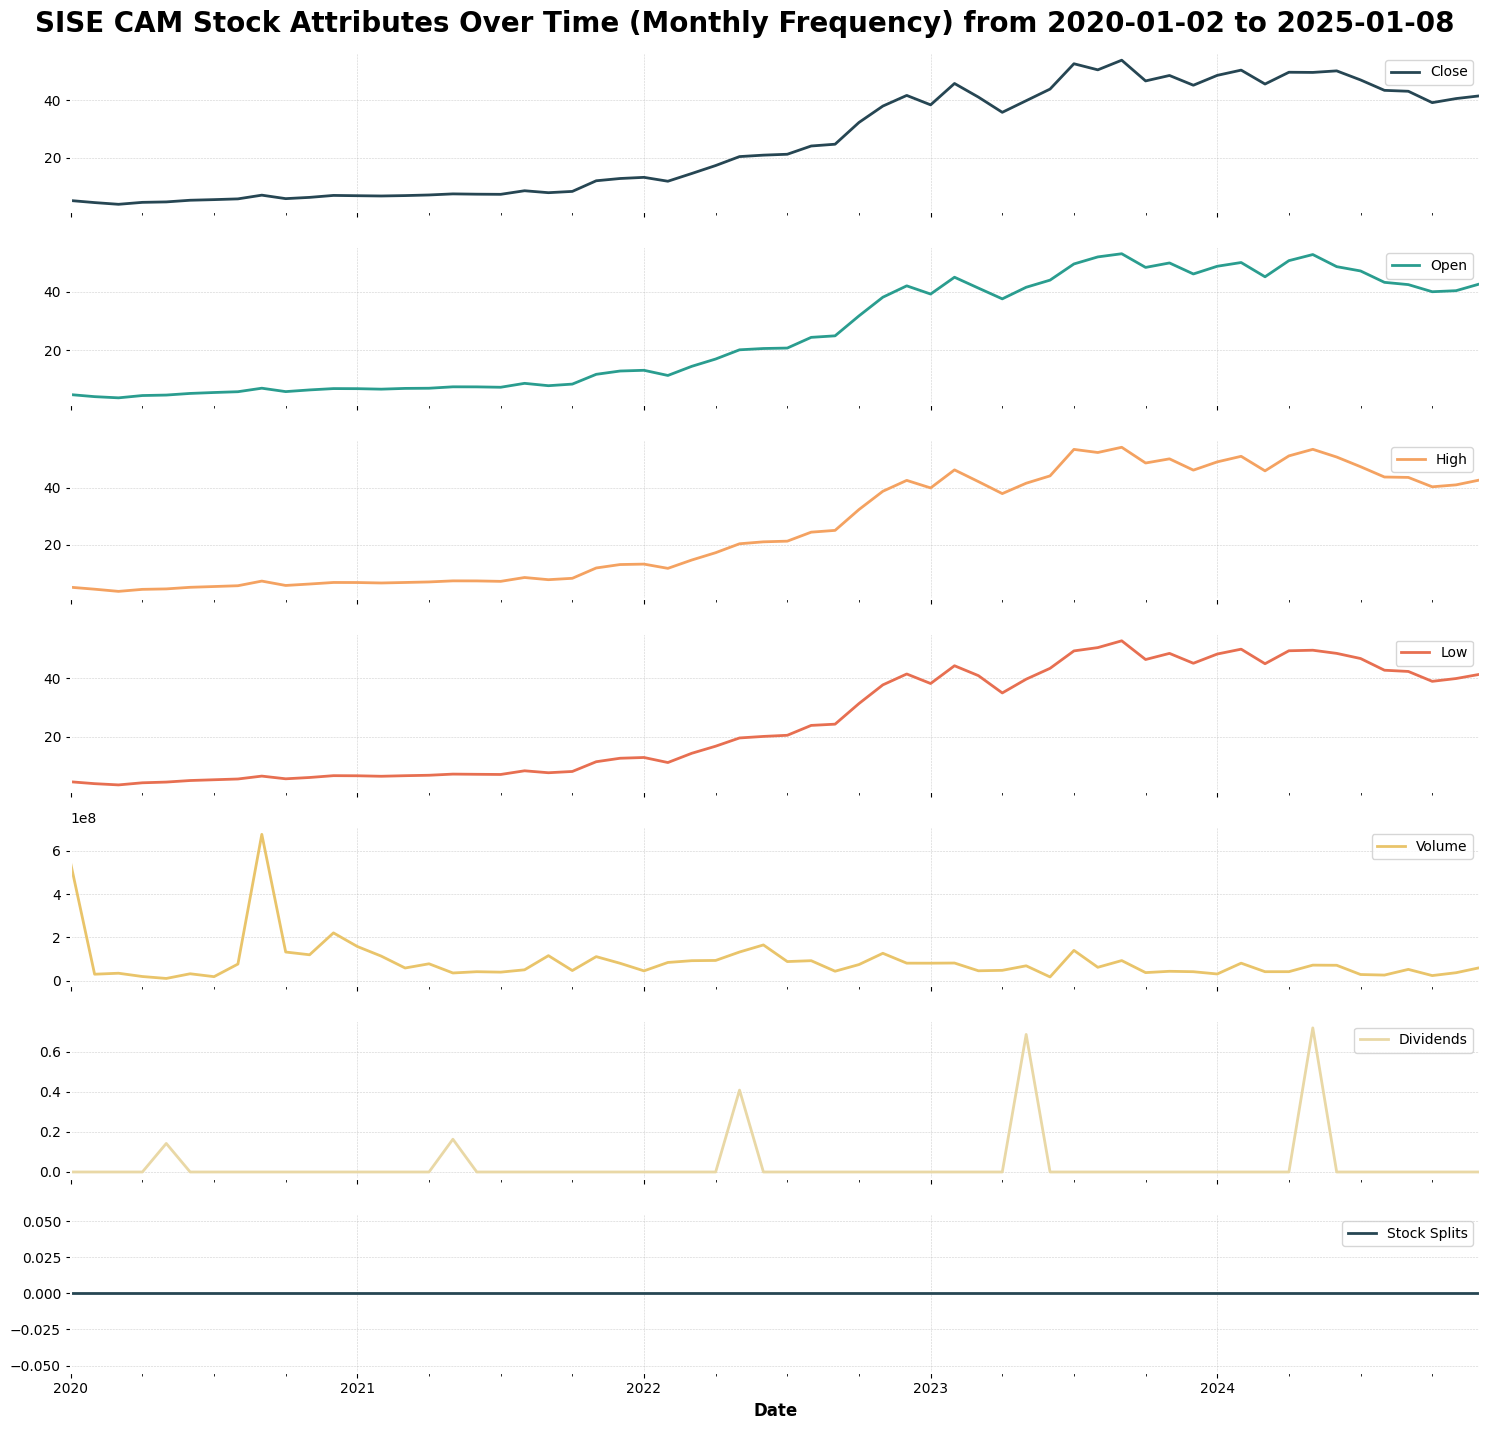

In [626]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']
df_weekly = df.asfreq('M', method='ffill')
df_weekly.plot(subplots=True, figsize=(15, 15), style='-', color=colors, linewidth=2)
end_date = df.index[-1].strftime('%Y-%m-%d')  # Verisetindeki son tarihi al
plt.suptitle(f'{tck.info["shortName"]} Stock Attributes Over Time (Monthly Frequency) from {start_date} to {end_date}', fontsize=20, y=0.95)
for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [627]:
candletrace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick',
    increasing=dict(line=dict(color='#2a9d8f')),
    decreasing=dict(line=dict(color='#f4a261')))
# layout for the chart with custom colors
end_date = df.index[-1].strftime('%Y-%m-%d')
layout = go.Layout(
    title=f'{tck.info["shortName"]} Candlestick Chart from {start_date} to {end_date}',
    xaxis=dict(title='Date', color='#2a9d8f'),
    yaxis=dict(title='Price', color='#2a9d8f', rangemode='normal'),
    plot_bgcolor='rgba(0,0,0,0)',  # transparent background
    paper_bgcolor='rgba(255,255,255,0.85)')  # slight transparency on paper background)
# creating the figure
fig = go.Figure(data=[candletrace], layout=layout)
# removing the range slider and showing the figure
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

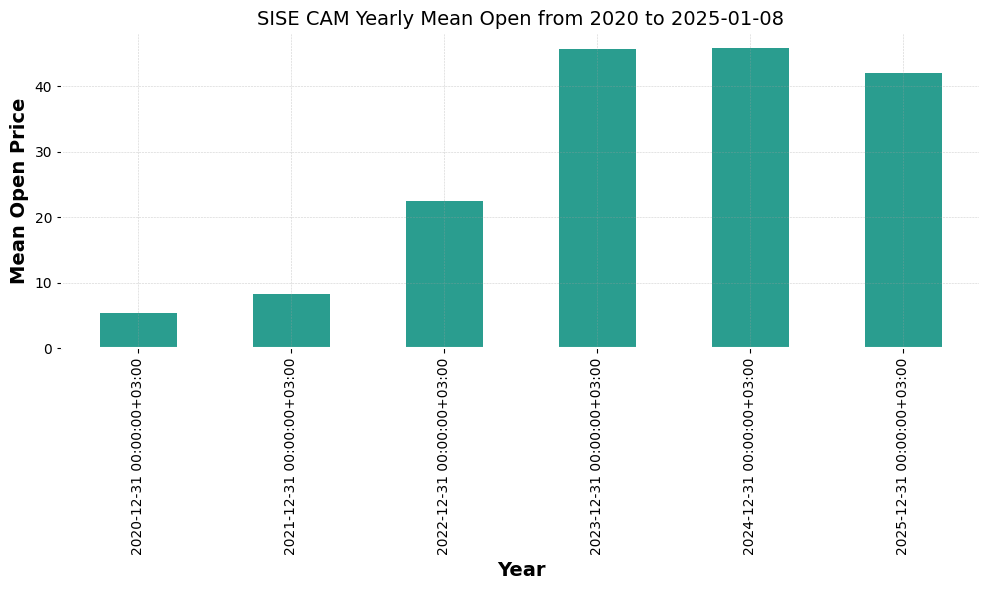

In [628]:
import math
import yfinance as yf
import datetime as dt
# Resampling the 'Open' data by year-end and plotting the mean values
plt.figure(figsize=(10, 6))  # Set figure size
df['Open'].resample('A').mean().plot(kind='bar', color='#2a9d8f')  # Updated color
plt.title(f'{tck.info["shortName"]} Yearly Mean Open from {start_date[:4]} to {end_date}', fontsize=14)   # Title with larger font
plt.xlabel('Year', fontsize=14)  # X-axis label with larger font
plt.ylabel('Mean Open Price', fontsize=14)  # Y-axis label with larger font
plt.grid(True, linestyle='--', alpha=0.5)  # Grid with dashed lines
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

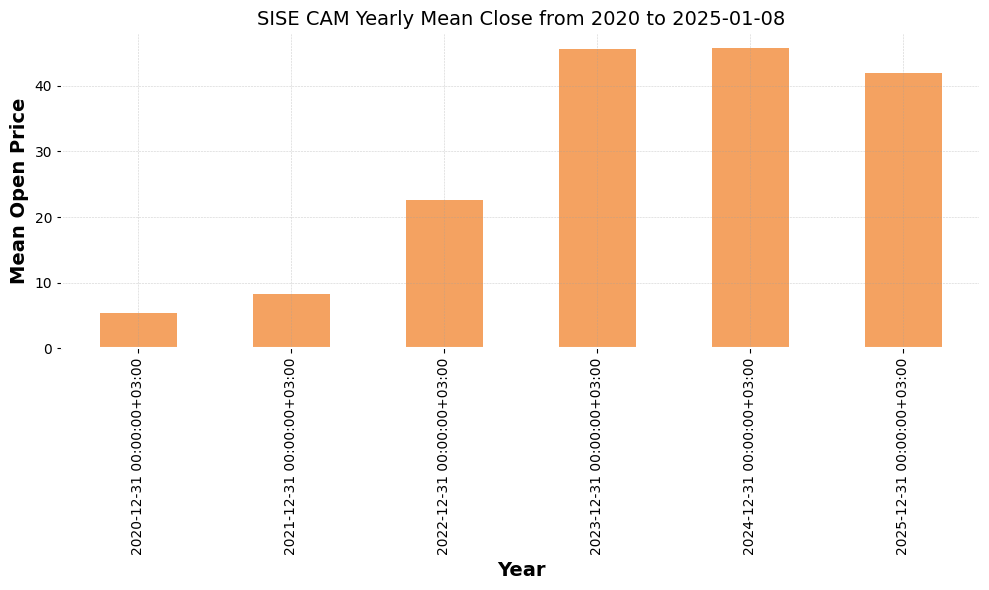

In [629]:
plt.figure(figsize=(10, 6)) 
df['Close'].resample('A').mean().plot(kind='bar', color='#f4a261')
plt.title(f'{tck.info["shortName"]} Yearly Mean Close from {start_date[:4]} to {end_date}', fontsize=14)
plt.xlabel('Year', fontsize=14)  
plt.ylabel('Mean Open Price', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()

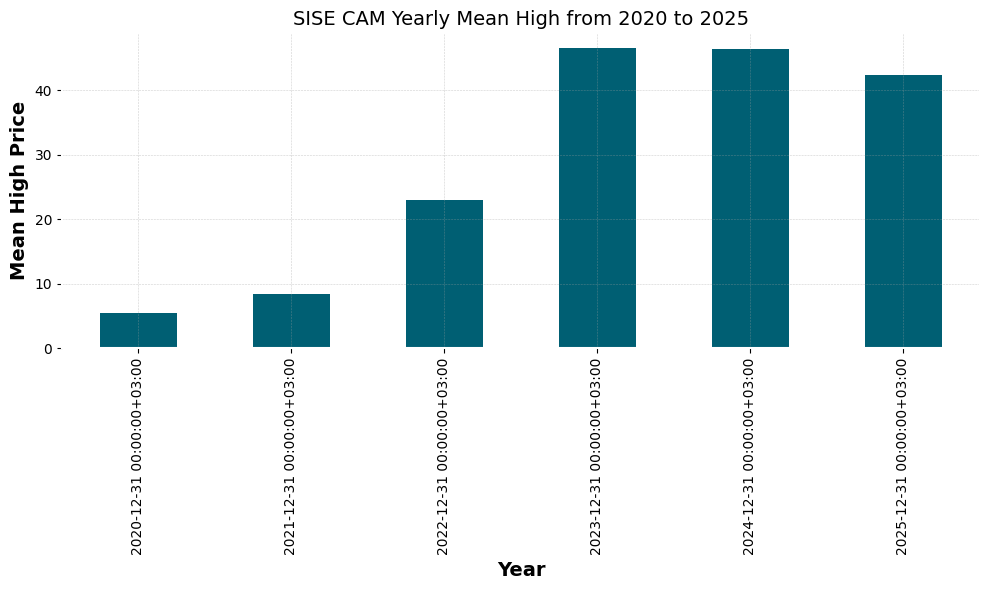

In [630]:
# Grafik boyutu ayarı
plt.figure(figsize=(10, 6))  
# Yıllık ortalama yüksek fiyatı çizme
df['High'].resample('A').mean().plot(kind='bar', color='#005f73')  # Renk güncellendi
# Başlık ve etiketler
end_date = df.index[-1].strftime('%Y')  # Verisetindeki son yıl
plt.title(f'{tck.info["shortName"]} Yearly Mean High from {start_date[:4]} to {end_date}', fontsize=14)  # Başlık dinamik hale getirildi
plt.xlabel('Year', fontsize=14)  # X ekseni etiketi
plt.ylabel('Mean High Price', fontsize=14)  # Y ekseni etiketi
# Grid ayarları
plt.grid(True, linestyle='--', alpha=0.5)  
# Düzeni ayarlama
plt.tight_layout()  
plt.show()

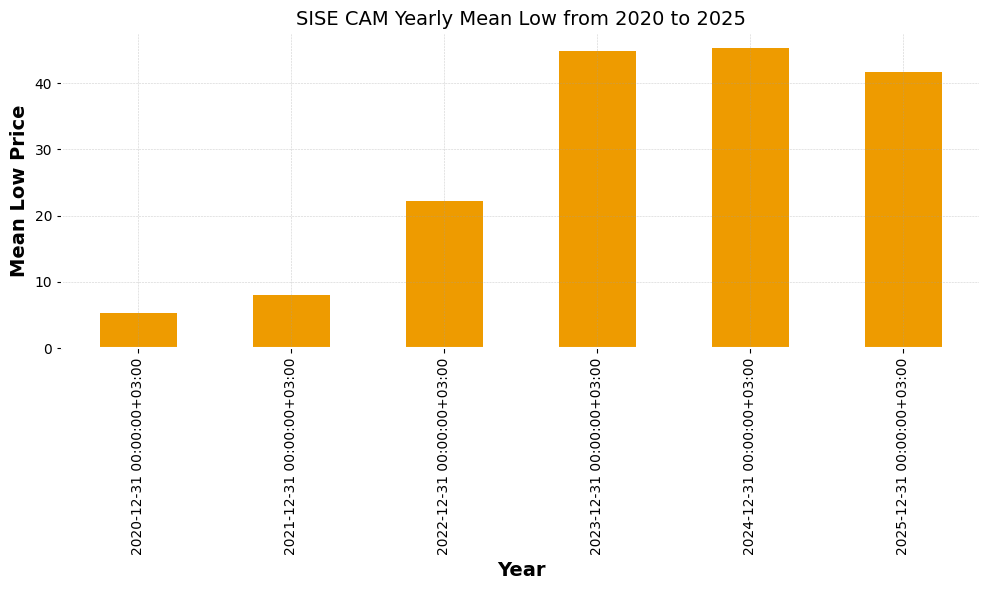

In [631]:
# Grafik boyutu ayarı
plt.figure(figsize=(10, 6))  
# Yıllık ortalama düşük fiyatı çizme
df['Low'].resample('A').mean().plot(kind='bar', color='#ee9b00')  # Renk güncellendi
# Başlık ve etiketler
end_date = df.index[-1].strftime('%Y')  # Verisetindeki son yıl
plt.title(f'{tck.info["shortName"]} Yearly Mean Low from {start_date[:4]} to {end_date}', fontsize=14)  
plt.xlabel('Year', fontsize=14)  # X ekseni etiketi
plt.ylabel('Mean Low Price', fontsize=14)  # Y ekseni etiketi
# Grid ayarları
plt.grid(True, linestyle='--', alpha=0.5)  
# Düzeni ayarlama
plt.tight_layout()  
plt.show()

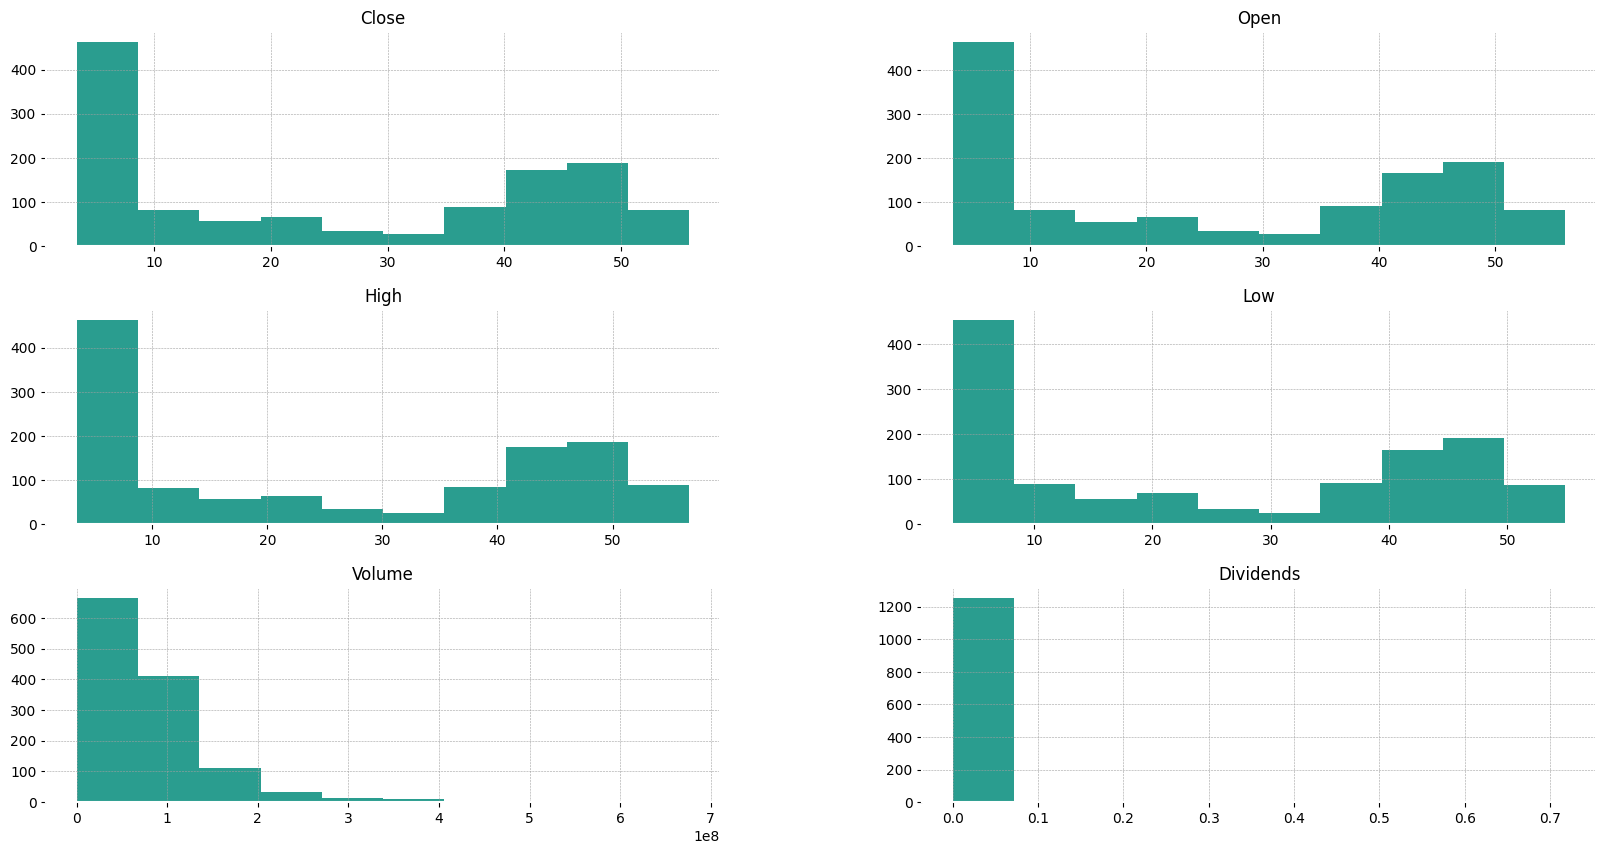

In [632]:
df1 = df.copy()
df1.drop("Stock Splits", axis=1, inplace=True)
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
hist=df1.hist(ax = ax , color= '#2a9d8f')

#### SMA  (Simple Moving Average)
Calculating the moving averages for certain periods and different window sizes.

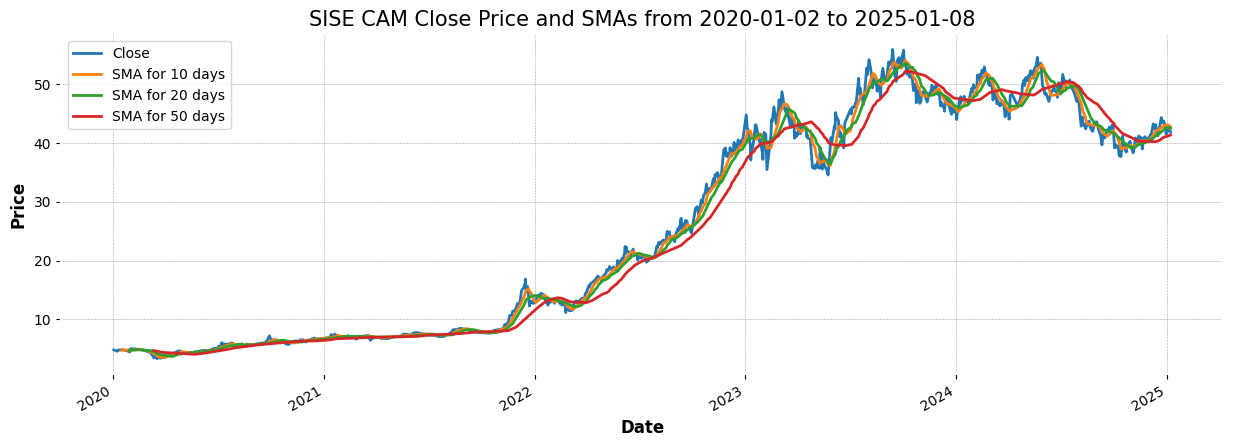

In [633]:
md = [10, 20, 50]
for SMA in md:
    col = f'SMA for {SMA} days'
    df[col] = df['Close'].rolling(SMA).mean()
# Grafik oluşturma
df[['Close', 'SMA for 10 days', 'SMA for 20 days', 'SMA for 50 days']].plot(figsize=(15, 5))
# Başlık ve etiketler
end_date = df.index[-1].strftime('%Y-%m-%d')  # Verisetindeki son tarihi al
plt.title(f'{tck.info["shortName"]} Close Price and SMAs from {start_date} to {end_date}', fontsize=15)  
plt.xlabel('Date', fontsize=12)  # X ekseni etiketi
plt.ylabel('Price', fontsize=12)  # Y ekseni etiketi
plt.show()

- Grafik, hareketli ortalamayı ölçmek için en uygun sürelerin '10 ve 20 gün' olduğunu göstermektedir, çünkü bunlar gürültüyü en aza indirirken verilerdeki eğilimleri etkili bir şekilde yakalamaktadır. (50 günlük hareketli ortalama orijinal verilerden bir miktar farklılık gösterirken, 10 günlük ve 20 günlük hareketli ortalamalar daha güçlü performans göstermektedir)

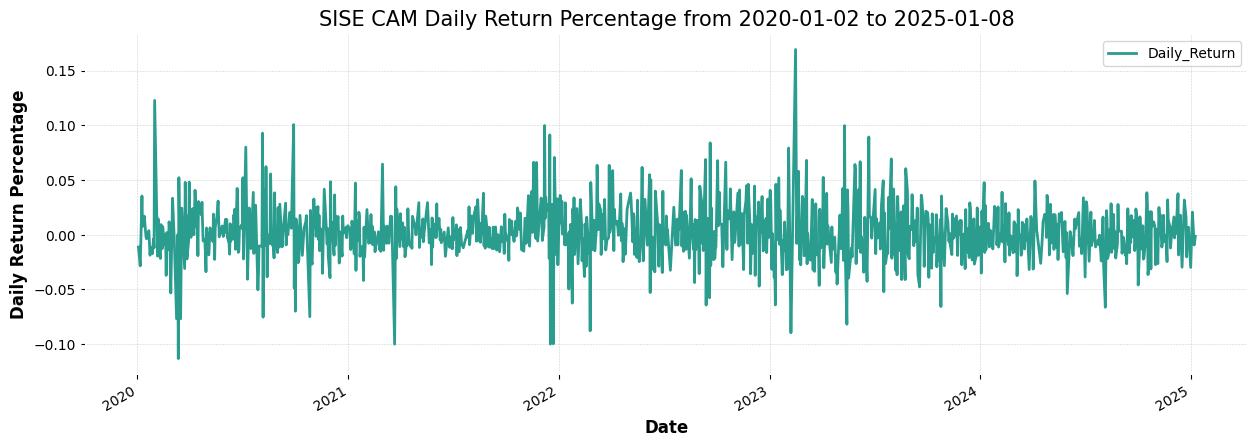

In [634]:
df['Daily_Return'] = df['Close'].pct_change()
# Grafik oluşturma
df['Daily_Return'].plot(legend=True, figsize=(15, 5), color='#2a9d8f', linewidth=2)
# Başlık ve etiketler
end_date = df.index[-1].strftime('%Y-%m-%d')  # Verisetindeki son tarihi al
plt.title(f'{tck.info["shortName"]} Daily Return Percentage from {start_date} to {end_date}', fontsize=15) 
plt.xlabel('Date', fontsize=12)  # X ekseni etiketi
plt.ylabel('Daily Return Percentage', fontsize=12)  # Y ekseni etiketi
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [635]:
# Create a deep copy of the original dataframe
df2 = df.copy(deep=True)
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
# Apply scaling to each column individually
df2['Open'] = scaler.fit_transform(df2.Open.values.reshape(-1, 1))
df2['High'] = scaler.fit_transform(df2.High.values.reshape(-1, 1))
df2['Low'] = scaler.fit_transform(df2.Low.values.reshape(-1, 1))
df2['Close'] = scaler.fit_transform(df2.Close.values.reshape(-1, 1))
df2['Volume'] = scaler.fit_transform(df2.Volume.values.reshape(-1, 1))
# Select the relevant columns for further processing
df3 = df2[['Open', 'High', 'Low', 'Volume', 'Close']].values
# Output the shape of the resulting dataframe
df3.shape

(1256, 5)

<a id="tf"></a>
<div style="background-color: #a8dadc; font-family: 'Verdana', sans-serif; font-size: 24px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">
    Modeling (Tensorflow)
</div>


<div style="border-radius:10px; border:maroon; padding: 15px; background-color: #ffffff; font-size:100%; text-align:left">
<h2 align="left"><font color='Black'>Time Series Forecasting with Recurrent Neural Networks (RNN)</font></h2>
<p style="color: black; text-align:left;">Zaman Serisi Verisi: Zaman serisinde, her veri noktası gözlemin yapıldığı zamanı belirten bir zaman damgası ile ilişkilidir. Bu tür veriler, finans, ekonomi, hava tahminleri ve makine öğrenimi gibi alanlarda yaygın olarak kullanılmaktadır. Zaman serisi verisinin önemli bir özelliği, zaman içinde mevsimsel değişimler veya döngüsel davranışlar gibi kalıplar veya eğilimler sergileme eğilimidir. Bu kalıpları analiz ederek tahminler yapılabilir ve temel olaylara dair içgörüler elde edilebilir.</p>

<p style="color: black; text-align:left;">Tekrarlayan Sinir Ağları (RNN), verilerdeki zamansal ilişkileri kullanarak önceki girdilere dair bir bellek biçimi korurlar. Bu, RNN'lerin sıralı zaman serisi verileri için özellikle uygun hale gelmesini sağlar. Gelecek değerleri tahmin etmek için kısa vadeli bellekte bilgi tutmak üzere oluşturulmuş bir model olan RNN, otokorelasyonların mevsimsellik göstermediğini ve son fiyatlardan etkilendiğini gösterdiği için veri setimiz için ideal görünmektedir. Ayrıca, veriler içindeki ilginç uzun vadeli bağımlılıkları veya ilişkileri ortaya çıkarabilecek bir RNN özel versiyonu olan LSTM'yi de uygulayacağız.</p>

#### Zaman Serisi İçin Verilerin Hazırlanması
Hisse senedi fiyatlarını tahmin etmek için veriyi bir zaman serisi sorunu olarak ele almamız gerekiyor. Bir sonraki günün fiyatını tahmin etmek için önceki 10 günün fiyatlarını kullanacağız. Gelin, dizileri buna göre oluşturalım:

In [636]:
seq_len = 11
sequence = []
for index in range(len(df3) - seq_len + 1): 
    sequence.append(df3[index: index + seq_len])
sequence = np.array(sequence)
print(sequence.shape)

(1246, 11, 5)


#### Veriyi Bölme
Veri setini eğitim setine (%80), test setine (%10) ve doğrulama setine (%10) ayırma.

In [637]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.2, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [638]:
train_data, val_data, test_data = split_data(sequence)
print("Train:", train_data.shape, "Validation:", val_data.shape, "Test:", test_data.shape)

Train: (996, 11, 5) Validation: (125, 11, 5) Test: (125, 11, 5)


In [639]:
x_train = train_data[:, :-1, :]
y_train = train_data[:, -1, -1] 
x_valid = val_data[:, :-1, :]
y_valid = val_data[:, -1, -1]
x_test = test_data[:, :-1, :]
y_test = test_data[:, -1, -1]
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (996, 10, 5)
y_train shape: (996,)
x_valid shape: (125, 10, 5)
y_valid shape: (125,)
x_test shape: (125, 10, 5)
y_test shape: (125,)


#### Modeli Tanımlama
Sıralı bilgileri yakalamak için Uzun Kısa Süreli Bellek (LSTM) kullanma.

In [640]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model_lstm.add(LSTM(units=32, return_sequences=False))
model_lstm.add(Dense(units=25))
model_lstm.add(Dense(units=1))
# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model_lstm.fit(x_train, y_train, epochs=50, batch_size=32,
                       validation_data=(x_valid, y_valid))

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1627 - val_loss: 0.0120
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0045
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0052
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_l

In [641]:
# Predict on the test data
y_pred = model_lstm.predict(x_test)
# Evaluate the predictions
test_loss = model_lstm.evaluate(x_test, y_test)
print("Test Loss:", test_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Test Loss: 0.0013681685086339712


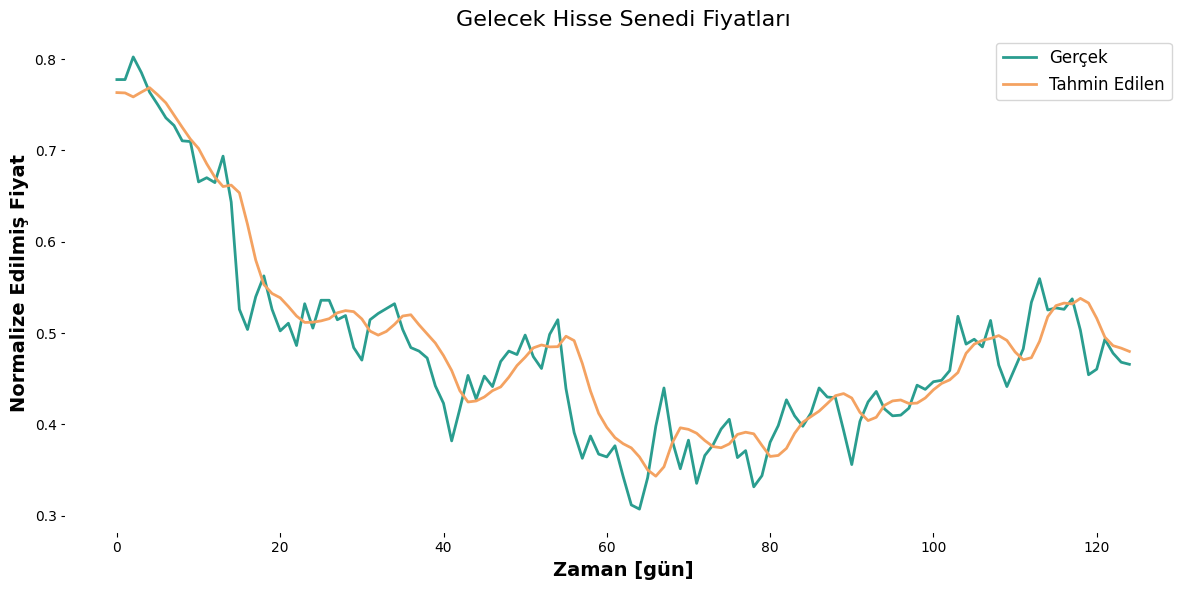

In [642]:
plt.figure(figsize=(12, 6))
idx = 0
plt.plot(y_test, color='#2a9d8f', label='Gerçek')  
plt.plot(y_pred, color='#f4a261', label='Tahmin Edilen') 
plt.title('Gelecek Hisse Senedi Fiyatları', fontsize=16)
plt.xlabel('Zaman [gün]', fontsize=14)
plt.ylabel('Normalize Edilmiş Fiyat', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.tight_layout() 
plt.show()

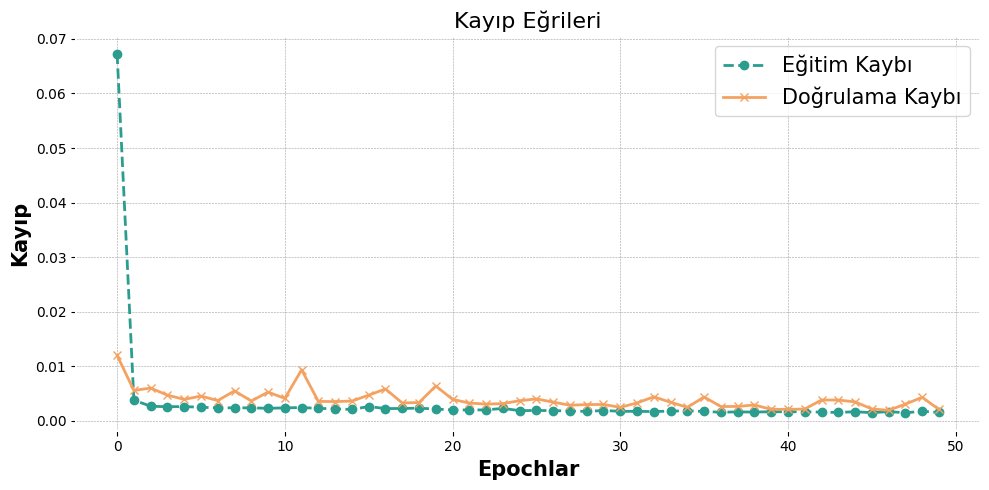

In [643]:
# Kayıp eğrilerini çizme
def plot_loss_curve(history):
    plt.figure(figsize=(10, 5))
    # Kayıp eğrisi
    plt.plot(history.history['loss'], label='Eğitim Kaybı', color='#2a9d8f', marker='o', linestyle='--')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='#f4a261', marker='x', linestyle='-')
    plt.title('Kayıp Eğrileri', fontsize=16)
    plt.xlabel('Epochlar', fontsize=15)
    plt.ylabel('Kayıp', fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Kayıp eğrisini çizmek için fonksiyonu çağır
plot_loss_curve(history)

In [644]:
print("### Model Summary ###")
model_lstm.summary()

### Model Summary ###


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,563 (365.48 KB)

 Trainable params: 31,187 (121.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,376 (243.66 KB)

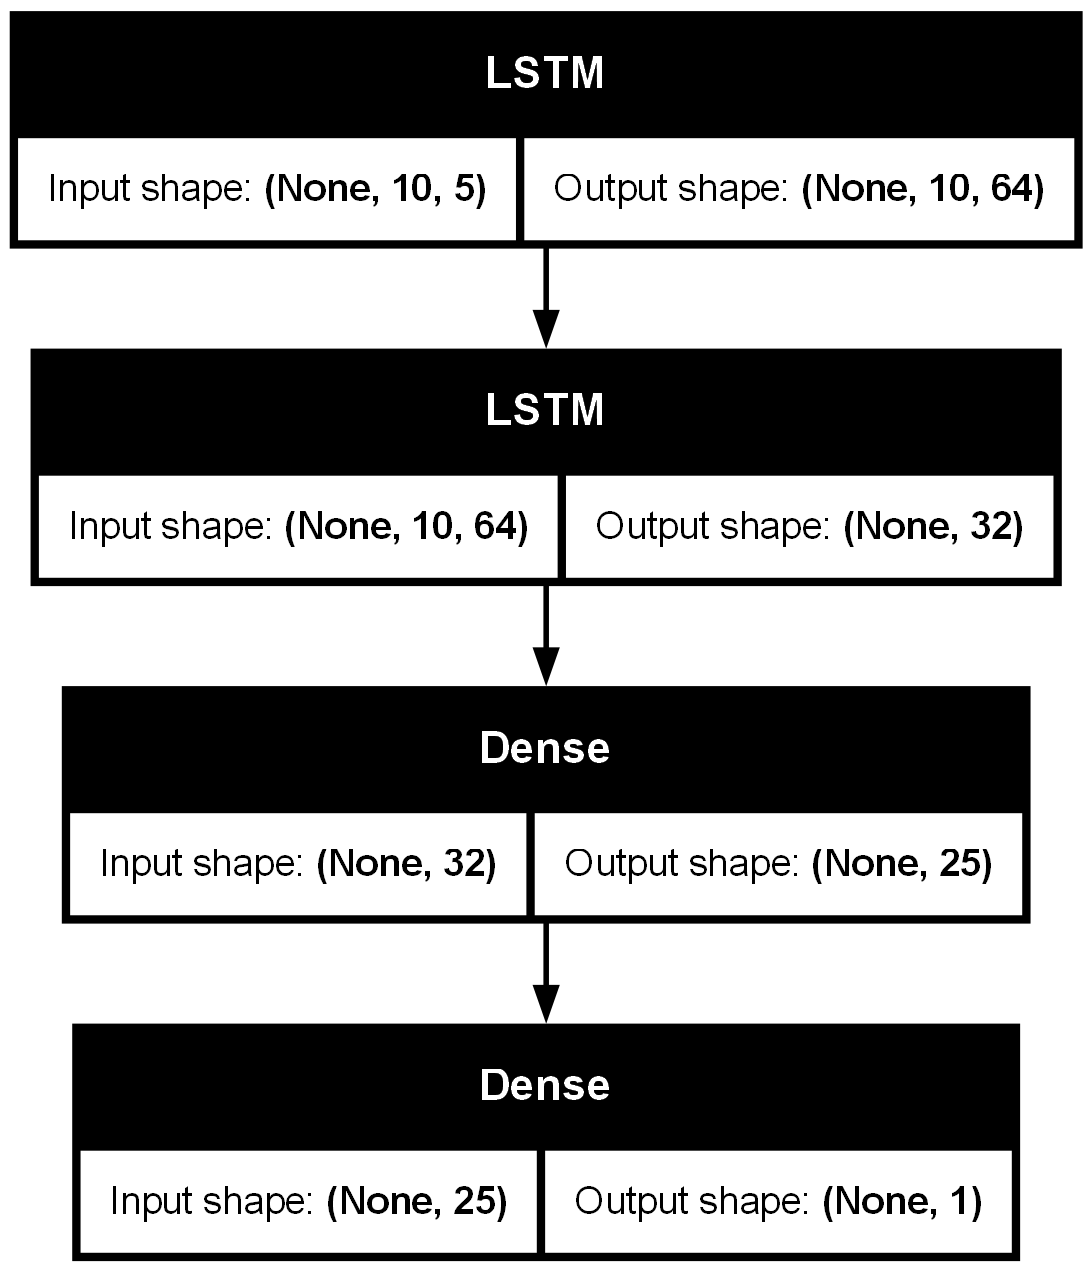

In [645]:
# # Save the model architecture as an image
plot_model(model_lstm, to_file='model_architecture.png', show_shapes=True)
# # Display the saved model architecture image
Image(filename='model_architecture.png')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


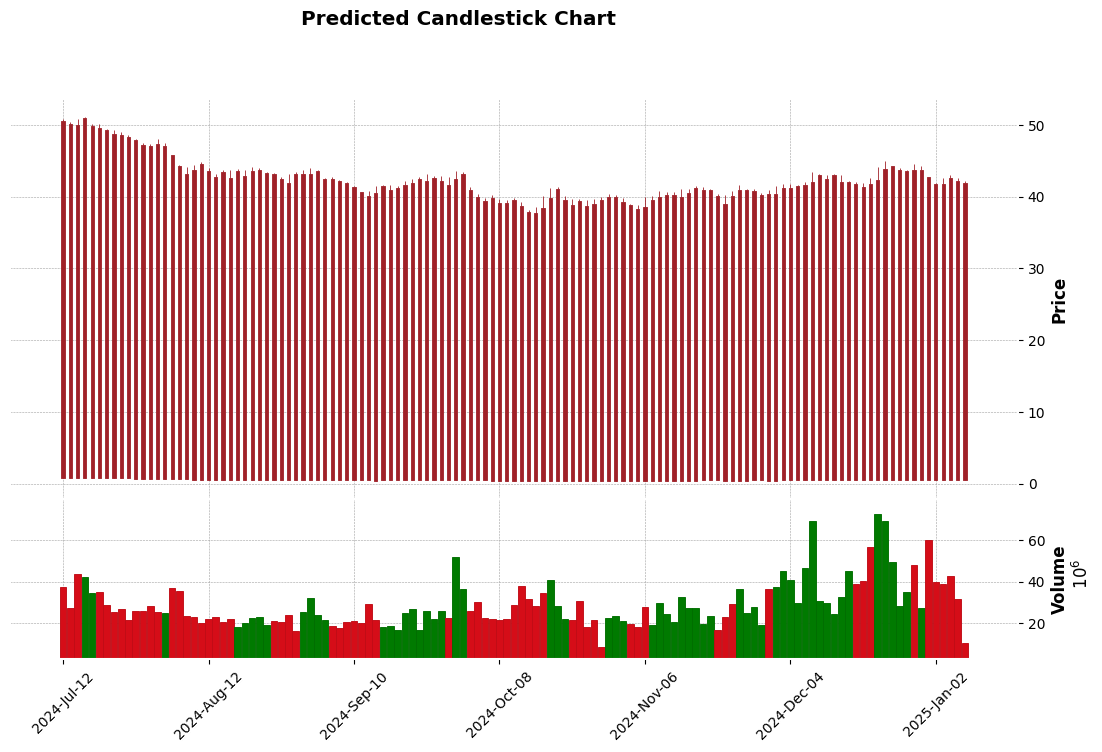

In [646]:
import mplfinance as mpf
predicted_prices = model_lstm.predict(x_test)
predicted_df = df.iloc[-len(predicted_prices):].copy()  
predicted_df['Predicted Close'] = predicted_prices
predicted_df['Open'] = predicted_df['Open']  
predicted_df['High'] = predicted_df['High']
predicted_df['Low'] = predicted_df['Low']
predicted_df['Close'] = predicted_df['Predicted Close']  
final_df = predicted_df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
final_df.index = pd.to_datetime(predicted_df.index) 
mpf.plot(
    final_df,
    type='candle',
    volume=True,
    style='charles',
    title="Predicted Candlestick Chart",
    ylabel="Price",
    ylabel_lower="Volume",
    figsize=(14, 8) 
)

In [647]:
df = df.reset_index()

In [648]:
# Assume df contains the main data with daily prices.
# Example data setup:
# df = pd.DataFrame({
#     'Open': [...],
#     'High': [...],
#     'Low': [...],
#     'Close': [...],
# })

# Ensure the DataFrame is ordered correctly
df['Date'] = pd.to_datetime(df['Date'])  # Assuming there is a column named Date
df.set_index('Date', inplace=True)
# Select prices for the candlestick
final_df = df[['Open', 'High', 'Low', 'Close']]
# Create the candlestick chart
candlestick_trace = go.Candlestick(
    x=final_df.index,
    open=final_df['Open'],
    high=final_df['High'],
    low=final_df['Low'],
    close=final_df['Close'],
    name='Candlestick',
    increasing_line_color='#2a9d8f',  # Color for increasing candles
    decreasing_line_color='#f4a261',    # Color for decreasing candles
)
# Create the figure
fig = go.Figure(data=[candlestick_trace])
# Add title and labels
fig.update_layout(
    title='Predicted Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,  # Disable the range slider below the chart
    template='plotly_white',            # Use a light template
    height=600,                         # Height of the chart
    width=1000                          # Width of the chart
)
# Show the chart
fig.show()

In [649]:
# Predicting the next 10 days
latest_prediction = []
last_seq = x_test[:-1]

for _ in range(10):
    prediction = model_lstm.predict(last_seq)
    latest_prediction.append(prediction)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [650]:
df = df.reset_index() 

In [651]:
predicted_data_next = np.array(latest_prediction).reshape(-1, 5)
last_date = df['Date'].max()
next_10_days = [last_date + timedelta(days=i) for i in range(1, 11)]

# Iterate over all features
for i, feature_name in enumerate(['Open', 'High', 'Low', 'Volume', 'Close']):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=next_10_days,
        y=predicted_data_next[:, i],
        mode='lines+markers',
        name=f'Predicted {feature_name.capitalize()} Prices',
        line=dict(color='#f4a261'), 
        marker=dict(color='#f4a261')  
    ))

    fig.update_layout(
        title=f'Predicted {feature_name.capitalize()} Prices for the Next 10 Days',
        xaxis_title='Date',
        yaxis_title=f'{feature_name.capitalize()} Price',
        plot_bgcolor='white' 
    )

    fig.show()

<a id="tf"></a>
<div style="background-color: #a8dadc; font-family: 'Verdana', sans-serif; font-size: 24px; color: #ffffff; text-align: center; border-radius: 15px; padding: 15px; border: 2px solid #ffffff; box-shadow: 0 4px 10px rgba(0, 0, 0, 0.2);">
    Modeling (PyTorch)
</div>

In [652]:
import os
if os.path.exists("model.pth"):
    os.remove("model.pth")
    
ticker_symbol = "SISE.IS"  

tck = yf.Ticker(ticker_symbol)
# Başlangıç tarihi
start_date = "2020-01-02"
# Tarihsel veriler
df5 = tck.history(start=start_date, end=None)
df5

Open       High        Low      Close  \
Date                                                                    
2020-01-02 00:00:00+03:00   4.792281   4.855695   4.774163   4.828517   
2020-01-03 00:00:00+03:00   4.801340   4.855695   4.683571   4.774162   
2020-01-06 00:00:00+03:00   4.746986   4.783223   4.620158   4.638276   
2020-01-07 00:00:00+03:00   4.692631   4.701690   4.620158   4.638276   
2020-01-08 00:00:00+03:00   4.529565   4.656393   4.493329   4.611098   
...                              ...        ...        ...        ...   
2025-01-02 00:00:00+03:00  41.759998  41.959999  41.380001  41.680000   
2025-01-03 00:00:00+03:00  41.759998  42.560001  41.720001  42.540001   
2025-01-06 00:00:00+03:00  42.619999  43.000000  41.520000  42.139999   
2025-01-07 00:00:00+03:00  42.160000  42.619999  41.860001  41.880001   
2025-01-08 00:00:00+03:00  41.900002  42.119999  41.639999  41.820000   

                             Volume  Dividends  Stock Splits  
Date                                                          
2020-01-02 00:00:00+03:00  62036079        0.0           0.0  
2020-01-03 00:00:00+03:00  62950188        0.0           0.0  
2020-01-06 00:00:00+03:00  65070398        0.0           0.0  
2020-01-07 00:00:00+03:00  39917326        0.0           0.0  
2020-01-08 00:00:00+03:00  54799214        0.0           0.0  
...                             ...        ...           ...  
2025-01-02 00:00:00+03:00  40016000        0.0           0.0  
2025-01-03 00:00:00+03:00  38835776        0.0           0.0  
2025-01-06 00:00:00+03:00  42872412        0.0           0.0  
2025-01-07 00:00:00+03:00  31582376        0.0           0.0  
2025-01-08 00:00:00+03:00  10449769        0.0           0.0  

[1256 rows x 7 columns]

In [653]:
df5 = df5.reset_index()  # This will move the index (Date) into a regular column.

In [654]:
df5['Volume'] = df5['Volume'].astype('float64')

In [655]:
sma_days = [10, 20, 50]
# Calculate SMAs for each window size and add them to the dataframe
for sma in sma_days:
    col_name = f'SMA_{sma}days'
    df5[col_name] = df5['Close'].rolling(sma).mean()

In [656]:
df5['SMA_10days'] = df5['SMA_10days'].fillna(df5['Close'])
df5['SMA_20days'] = df5['SMA_20days'].fillna(df5['Close'])
df5['SMA_50days'] = df5['SMA_50days'].fillna(df5['Close'])

df5.head(15)

Date      Open      High       Low     Close  \
0  2020-01-02 00:00:00+03:00  4.792281  4.855695  4.774163  4.828517   
1  2020-01-03 00:00:00+03:00  4.801340  4.855695  4.683571  4.774162   
2  2020-01-06 00:00:00+03:00  4.746986  4.783223  4.620158  4.638276   
3  2020-01-07 00:00:00+03:00  4.692631  4.701690  4.620158  4.638276   
4  2020-01-08 00:00:00+03:00  4.529565  4.656393  4.493329  4.611098   
5  2020-01-09 00:00:00+03:00  4.692630  4.783222  4.692630  4.774162   
6  2020-01-10 00:00:00+03:00  4.801340  4.837576  4.765103  4.810399   
7  2020-01-13 00:00:00+03:00  4.855695  4.928168  4.846636  4.891932   
8  2020-01-14 00:00:00+03:00  4.891932  4.946287  4.855696  4.910050   
9  2020-01-15 00:00:00+03:00  4.891931  4.982522  4.855695  4.900990   
10 2020-01-16 00:00:00+03:00  4.928168  5.000641  4.882872  4.891932   
11 2020-01-17 00:00:00+03:00  4.937226  4.955345  4.837576  4.873813   
12 2020-01-20 00:00:00+03:00  4.891932  4.928168  4.873813  4.891932   
13 2020-01-21 00:00:00+03:00  4.873814  4.910050  4.837577  4.910050   
14 2020-01-22 00:00:00+03:00  4.919109  4.928168  4.828518  4.837577   

         Volume  Dividends  Stock Splits  SMA_10days  SMA_20days  SMA_50days  
0    62036079.0        0.0           0.0    4.828517    4.828517    4.828517  
1    62950188.0        0.0           0.0    4.774162    4.774162    4.774162  
2    65070398.0        0.0           0.0    4.638276    4.638276    4.638276  
3    39917326.0        0.0           0.0    4.638276    4.638276    4.638276  
4    54799214.0        0.0           0.0    4.611098    4.611098    4.611098  
5    66003546.0        0.0           0.0    4.774162    4.774162    4.774162  
6    56652865.0        0.0           0.0    4.810399    4.810399    4.810399  
7    75450934.0        0.0           0.0    4.891932    4.891932    4.891932  
8    75875277.0        0.0           0.0    4.910050    4.910050    4.910050  
9   113224780.0        0.0           0.0    4.777786    4.900990    4.900990  
10   79506060.0        0.0           0.0    4.784128    4.891932    4.891932  
11   41919577.0        0.0           0.0    4.794093    4.873813    4.873813  
12   41829055.0        0.0           0.0    4.819458    4.891932    4.891932  
13   38004781.0        0.0           0.0    4.846636    4.910050    4.910050  
14   48756390.0        0.0           0.0    4.869284    4.837577    4.837577

In [657]:
ten_days = df5[['Open','High','Low', 'Volume','SMA_10days','Close']].copy(deep=True)
twenty_days = df5[['Open','High','Low', 'Volume','SMA_20days','Close']].copy(deep=True)
all_sma = df5[['Open','High','Low', 'Volume','SMA_10days','SMA_20days','Close']].copy(deep=True)

In [658]:
# Scaling

# 10 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(ten_days.Low.values.reshape(-1,1))
ten_days['Open'] = scaler.transform(ten_days.Open.values.reshape(-1,1))
ten_days['High'] = scaler.transform(ten_days.High.values.reshape(-1,1))
ten_days['Low'] = scaler.transform(ten_days.Low.values.reshape(-1,1))
ten_days['Volume'] = scaler.transform(ten_days.Volume.values.reshape(-1,1))
ten_days['Close'] = scaler.transform(ten_days.Close.values.reshape(-1,1))
ten_days['SMA_10days'] = scaler.transform(ten_days['SMA_10days'].values.reshape(-1,1))

# 20 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(twenty_days.Low.values.reshape(-1,1))
twenty_days['Open'] = scaler.transform(twenty_days.Open.values.reshape(-1,1))
twenty_days['High'] = scaler.transform(twenty_days.High.values.reshape(-1,1))
twenty_days['Low'] = scaler.transform(twenty_days.Low.values.reshape(-1,1))
twenty_days['Volume'] = scaler.transform(twenty_days.Volume.values.reshape(-1,1))
twenty_days['Close'] = scaler.transform(twenty_days.Close.values.reshape(-1,1))
twenty_days['SMA_20days'] = scaler.transform(twenty_days['SMA_20days'].values.reshape(-1,1))

# Both 10 & 20 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(all_sma.Low.values.reshape(-1,1))
all_sma['Open'] = scaler.transform(all_sma.Open.values.reshape(-1,1))
all_sma['High'] = scaler.transform(all_sma.High.values.reshape(-1,1))
all_sma['Low'] = scaler.transform(all_sma.Low.values.reshape(-1,1))
all_sma['Volume'] = scaler.transform(all_sma.Volume.values.reshape(-1,1))
all_sma['Close'] = scaler.transform(all_sma.Close.values.reshape(-1,1))
all_sma['SMA_10days'] = scaler.transform(all_sma['SMA_10days'].values.reshape(-1,1))
all_sma['SMA_20days'] = scaler.transform(all_sma['SMA_20days'].values.reshape(-1,1))

In [659]:
# rescaled dataframes 
data_10days = ten_days[['Open','High','Low', 'SMA_10days','Close']].values
data_20days = twenty_days[['Open','High','Low','SMA_20days','Close']].values
data_all = all_sma[['Open','High','Low', 'SMA_10days','SMA_20days','Close']].values

In [660]:
print(data_10days.shape)
print(data_20days.shape)
print(data_all.shape)

(1256, 5)
(1256, 5)
(1256, 6)


In [661]:
# using the price of the previous 10 days to predict the next day price
seq_len = 11

# 10 days SMA sequence
sequence_10days = []
for index in range(len(data_10days) - seq_len + 1): 
    sequence_10days.append(data_10days[index: index + seq_len])
sequence_10days = np.array(sequence_10days)
print(sequence_10days.shape)

# 20 days SMA sequence
sequence_20days = []
for index in range(len(data_20days) - seq_len + 1): 
    sequence_20days.append(data_20days[index: index + seq_len])
sequence_20days = np.array(sequence_20days)
print(sequence_20days.shape)

# Both SMAs sequence
sequence_all = []
for index in range(len(data_all) - seq_len + 1): 
    sequence_all.append(data_all[index: index + seq_len])
sequence_all = np.array(sequence_all)
print(sequence_all.shape)

(1246, 11, 5)
(1246, 11, 5)
(1246, 11, 6)


In [662]:
# split data
train_data_10days, val_data_10days, test_data_10days = split_data(sequence_10days)
train_data_20days, val_data_20days, test_data_20days = split_data(sequence_20days)
train_data_all, val_data_all, test_data_all = split_data(sequence_all)

In [663]:
ORANGE = "\033[38;5;214m"
RESET = "\033[0m"

# Check shapes of the split data
print(f"{ORANGE}Shapes:\n{RESET}")
print(f"{ORANGE}10 days SMA sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_10days.shape} {ORANGE}Validation:{RESET} {val_data_10days.shape} {ORANGE}Test:{RESET} {test_data_10days.shape}")
print(f"{ORANGE}20 days SMA sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_20days.shape} {ORANGE}Validation:{RESET} {val_data_20days.shape} {ORANGE}Test:{RESET} {test_data_20days.shape}")
print(f"{ORANGE}Both SMAs sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_all.shape} {ORANGE}Validation:{RESET} {val_data_all.shape} {ORANGE}Test:{RESET} {test_data_all.shape}")

Shapes:

10 days SMA sequence:
Train: (996, 11, 5) Validation: (125, 11, 5) Test: (125, 11, 5)
20 days SMA sequence:
Train: (996, 11, 5) Validation: (125, 11, 5) Test: (125, 11, 5)
Both SMAs sequence:
Train: (996, 11, 6) Validation: (125, 11, 6) Test: (125, 11, 6)


In [664]:
# Split X and Y for each dataset
def split_Xy(dataset):
    # Extract features (X) and target (Y)
    X = dataset[:, :-1, :]
    Y = dataset[:, -1, -1]   #last column (close price)
    return X, Y
# Split X and Y for each dataset
x_train_10d, y_train_10d = split_Xy(train_data_10days)
x_val_10d, y_val_10d = split_Xy(val_data_10days)
x_test_10d, y_test_10d = split_Xy(test_data_10days)
x_train_20d, y_train_20d = split_Xy(train_data_20days)
x_val_20d, y_val_20d = split_Xy(val_data_20days)
x_test_20d, y_test_20d = split_Xy(test_data_20days)
x_train_all, y_train_all = split_Xy(train_data_all)
x_val_all, y_val_all = split_Xy(val_data_all)
x_test_all, y_test_all = split_Xy(test_data_all)
print(x_train_10d.shape, y_train_10d.shape)
print(x_val_10d.shape, y_val_10d.shape)

(996, 10, 5) (996,)
(125, 10, 5) (125,)


In [665]:
# dataloader
batch_size = 64
# 10 days SMA
x_train_10d = torch.tensor(x_train_10d).float()
y_train_10d = torch.tensor(y_train_10d).float()
x_val_10d = torch.tensor(x_val_10d).float()
y_val_10d = torch.tensor(y_val_10d).float()
train_set_10d = TensorDataset(x_train_10d,y_train_10d)
train_dataloader_10d = DataLoader(train_set_10d, batch_size=32, shuffle=False)
val_set_10d = TensorDataset(x_val_10d ,y_val_10d)
val_dataloader_10d = DataLoader(val_set_10d, batch_size=32, shuffle=False)
# 20 days SMA
x_train_20d = torch.tensor(x_train_20d).float()
y_train_20d = torch.tensor(y_train_20d).float()
x_val_20d = torch.tensor(x_val_20d).float()
y_val_20d = torch.tensor(y_val_20d).float()
train_set_20d = TensorDataset(x_train_20d,y_train_20d)
train_dataloader_20d = DataLoader(train_set_20d, batch_size=32, shuffle=False)
val_set_20d = TensorDataset(x_val_20d, y_val_20d)
val_dataloader_20d = DataLoader(val_set_20d, batch_size=32, shuffle=False)
# 10 & 20 days SMA
x_train_all = torch.tensor(x_train_all).float()
y_train_all = torch.tensor(y_train_all).float()
x_val_all = torch.tensor(x_val_all).float()
y_val_all = torch.tensor(y_val_all).float()
train_set_all = TensorDataset(x_train_all,y_train_all)
train_dataloader_all = DataLoader(train_set_all, batch_size=32, shuffle=False)
val_set_all = TensorDataset(x_val_all,y_val_all)
val_dataloader_all = DataLoader(val_set_all, batch_size=32, shuffle=False)

In [666]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm = nn.LSTM(num_feature, 64, batch_first=True)  # 64 represents the number of hidden units in the LSTM layer
        self.dropout = nn.Dropout(p=0.5)  # Adding Dropout layer with a dropout probability of 0.5
        self.fc = nn.Linear(64, num_feature)
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.dropout(hidden[-1])  # Apply dropout to the last hidden state
        x = self.fc(x)
        return x
mse = nn.MSELoss()
epochs = 50

In [667]:
def train(model, dataloader, optimizer, criterion):
    model.train()  
    epoch_loss = 0
    for inputs, target in dataloader:
        optimizer.zero_grad()  
        # Forward pass
        prediction = model(inputs)  
        target = target.unsqueeze(-1)  # Reshape target to match prediction shape
        loss = criterion(prediction, target)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize
        epoch_loss += loss.item()
    return epoch_loss

In [668]:
def evaluate(model, dataloader, criterion):
    model.eval()  
    epoch_loss = 0
    with torch.no_grad():
        for inputs, target in dataloader:
            prediction = model(inputs) 
            target = target.unsqueeze(-1)  # Reshape target to match prediction shape
            loss = criterion(prediction, target)  # Calculate the loss
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

Model architecture saved as 'model_lstm.png'.


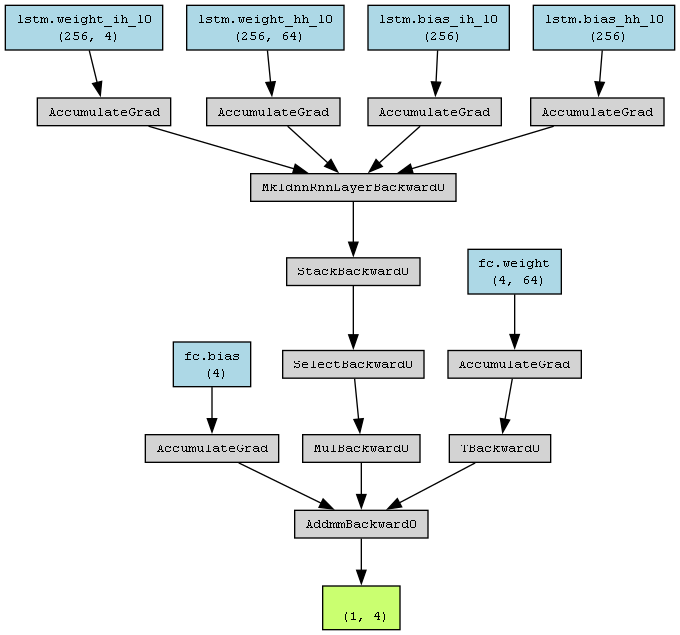

In [669]:
# Create the model instance
num_feature = 4  # Adjust this according to your features
model = NeuralNetwork(num_feature)
# Push to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Generate a random input tensor
x = torch.randn(1, 10, num_feature).to(device)  # (batch_size, sequence_length, num_features)
# Visualize the model architecture using torchviz
try:
    y = model(x)  # Forward pass to generate graph
    graph = make_dot(y, params=dict(model.named_parameters()))
    graph.render("model_lstm", format="png")  # Save as PNG
    print("Model architecture saved as 'model_lstm.png'.")
    # Display the saved image in the Jupyter Notebook
    display(Image(filename="model_lstm.png"))
except Exception as e:
    print(f"Error plotting model architecture: {e}")

In [670]:
model_10d = NeuralNetwork(5)
optimizer = optim.Adam(model_10d.parameters())

In [671]:
train_losses = []
valid_losses = []
for epoch in range(1, epochs + 1):
    # Training
    train_loss = train(model_10d, train_dataloader_10d, optimizer, mse)
    train_losses.append(train_loss)
    # Validation
    valid_loss = evaluate(model_10d, val_dataloader_10d, mse)
    valid_losses.append(valid_loss)
    # Print epoch statistics
    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/50], Train Loss: 12.4256, Valid Loss: 0.3438
Epoch [2/50], Train Loss: 5.2689, Valid Loss: 0.0264
Epoch [3/50], Train Loss: 2.4392, Valid Loss: 0.0531
Epoch [4/50], Train Loss: 2.1469, Valid Loss: 0.0989
Epoch [5/50], Train Loss: 1.6901, Valid Loss: 0.0054
Epoch [6/50], Train Loss: 1.2420, Valid Loss: 0.0295
Epoch [7/50], Train Loss: 1.2650, Valid Loss: 0.0044
Epoch [8/50], Train Loss: 1.0482, Valid Loss: 0.0063
Epoch [9/50], Train Loss: 1.0804, Valid Loss: 0.0146
Epoch [10/50], Train Loss: 1.0396, Valid Loss: 0.0080
Epoch [11/50], Train Loss: 0.9664, Valid Loss: 0.0078
Epoch [12/50], Train Loss: 0.8879, Valid Loss: 0.0182
Epoch [13/50], Train Loss: 0.9004, Valid Loss: 0.0075
Epoch [14/50], Train Loss: 0.9694, Valid Loss: 0.0055
Epoch [15/50], Train Loss: 0.8788, Valid Loss: 0.0055
Epoch [16/50], Train Loss: 0.8184, Valid Loss: 0.0079
Epoch [17/50], Train Loss: 0.7073, Valid Loss: 0.0038
Epoch [18/50], Train Loss: 0.7501, Valid Loss: 0.0028
Epoch [19/50], Train Loss: 0.9697, V

In [672]:
x_test_10d = torch.tensor(x_test_10d).float()
y_test_10d = torch.tensor(y_test_10d).float()
# Predict on the test data
with torch.no_grad():
    y_pred_10d = model_10d(x_test_10d)
# Convert predictions and actual test data to numpy arrays
y_pred_10d = y_pred_10d.numpy()
y_test_10d = y_test_10d.numpy()
# Reshape and select last element from prediction (closing price)
y_pred_10d = y_pred_10d.reshape(-1, y_pred_10d.shape[-1])[:, -1]

In [673]:
model_20d = NeuralNetwork(5)
optimizer = optim.Adam(model_20d.parameters())

In [674]:
train_losses = []
valid_losses = []
for epoch in range(1, epochs + 1):
    # Training
    train_loss = train(model_20d, train_dataloader_20d, optimizer, mse)
    train_losses.append(train_loss)
    # Validation
    valid_loss = evaluate(model_20d, val_dataloader_20d, mse)
    valid_losses.append(valid_loss)
    # Print epoch statistics
    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/50], Train Loss: 7.3568, Valid Loss: 0.1744
Epoch [2/50], Train Loss: 11.8379, Valid Loss: 0.1547
Epoch [3/50], Train Loss: 3.4853, Valid Loss: 0.0604
Epoch [4/50], Train Loss: 1.5619, Valid Loss: 0.0211
Epoch [5/50], Train Loss: 1.4933, Valid Loss: 0.0038
Epoch [6/50], Train Loss: 1.4086, Valid Loss: 0.0097
Epoch [7/50], Train Loss: 1.2236, Valid Loss: 0.0140
Epoch [8/50], Train Loss: 1.1216, Valid Loss: 0.0078
Epoch [9/50], Train Loss: 1.1796, Valid Loss: 0.0055
Epoch [10/50], Train Loss: 1.1853, Valid Loss: 0.0128
Epoch [11/50], Train Loss: 1.4946, Valid Loss: 0.0075
Epoch [12/50], Train Loss: 1.0217, Valid Loss: 0.0035
Epoch [13/50], Train Loss: 1.1722, Valid Loss: 0.0187
Epoch [14/50], Train Loss: 1.2430, Valid Loss: 0.0177
Epoch [15/50], Train Loss: 1.3624, Valid Loss: 0.0260
Epoch [16/50], Train Loss: 1.1158, Valid Loss: 0.0248
Epoch [17/50], Train Loss: 0.9244, Valid Loss: 0.0105
Epoch [18/50], Train Loss: 0.8226, Valid Loss: 0.0163
Epoch [19/50], Train Loss: 1.3302, V

In [675]:
x_test_20d = torch.tensor(x_test_20d).float()
y_test_20d = torch.tensor(y_test_20d).float()
# Predict on the test data
with torch.no_grad():
    y_pred_20d = model_20d(x_test_20d)
# Convert predictions and actual test data to numpy arrays
y_pred_20d = y_pred_20d.numpy()
y_test_20d = y_test_20d.numpy()
# Reshape and select last element from prediction (closing price)
y_pred_20d = y_pred_20d.reshape(-1, y_pred_20d.shape[-1])[:, -1]

In [676]:
model_all = NeuralNetwork(6)
optimizer = optim.Adam(model_all.parameters())

In [677]:
epochs=100
train_losses = []
valid_losses = []
for epoch in range(1, epochs + 1):
    # Training
    train_loss = train(model_all, train_dataloader_all, optimizer, mse)
    train_losses.append(train_loss)
    # Validation
    valid_loss = evaluate(model_all, val_dataloader_all, mse)
    valid_losses.append(valid_loss)
    # Print epoch statistics
    print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/100], Train Loss: 5.6878, Valid Loss: 0.0779
Epoch [2/100], Train Loss: 10.1166, Valid Loss: 0.0862
Epoch [3/100], Train Loss: 3.5258, Valid Loss: 0.1250
Epoch [4/100], Train Loss: 1.5876, Valid Loss: 0.0118
Epoch [5/100], Train Loss: 1.5224, Valid Loss: 0.0084
Epoch [6/100], Train Loss: 1.6195, Valid Loss: 0.0239
Epoch [7/100], Train Loss: 1.3366, Valid Loss: 0.0036
Epoch [8/100], Train Loss: 1.2098, Valid Loss: 0.0168
Epoch [9/100], Train Loss: 1.0801, Valid Loss: 0.0194
Epoch [10/100], Train Loss: 1.0746, Valid Loss: 0.0042
Epoch [11/100], Train Loss: 1.0668, Valid Loss: 0.0037
Epoch [12/100], Train Loss: 1.0781, Valid Loss: 0.0134
Epoch [13/100], Train Loss: 0.9750, Valid Loss: 0.0046
Epoch [14/100], Train Loss: 0.9010, Valid Loss: 0.0043
Epoch [15/100], Train Loss: 1.0072, Valid Loss: 0.0073
Epoch [16/100], Train Loss: 1.1745, Valid Loss: 0.0053
Epoch [17/100], Train Loss: 1.4819, Valid Loss: 0.0196
Epoch [18/100], Train Loss: 1.3227, Valid Loss: 0.0627
Epoch [19/100], Tr

In [678]:
x_test_all = torch.tensor(x_test_all).float()
y_test_all = torch.tensor(y_test_all).float()
# predict on the test data
with torch.no_grad():
    y_pred_all = model_all(x_test_all)
y_pred_all = y_pred_all.numpy()
y_test_all = y_test_all.numpy()
# reshape & select last element from prediction (closing price)
y_pred_all = y_pred_all.reshape(-1, y_pred_all.shape[-1])[:, -1]

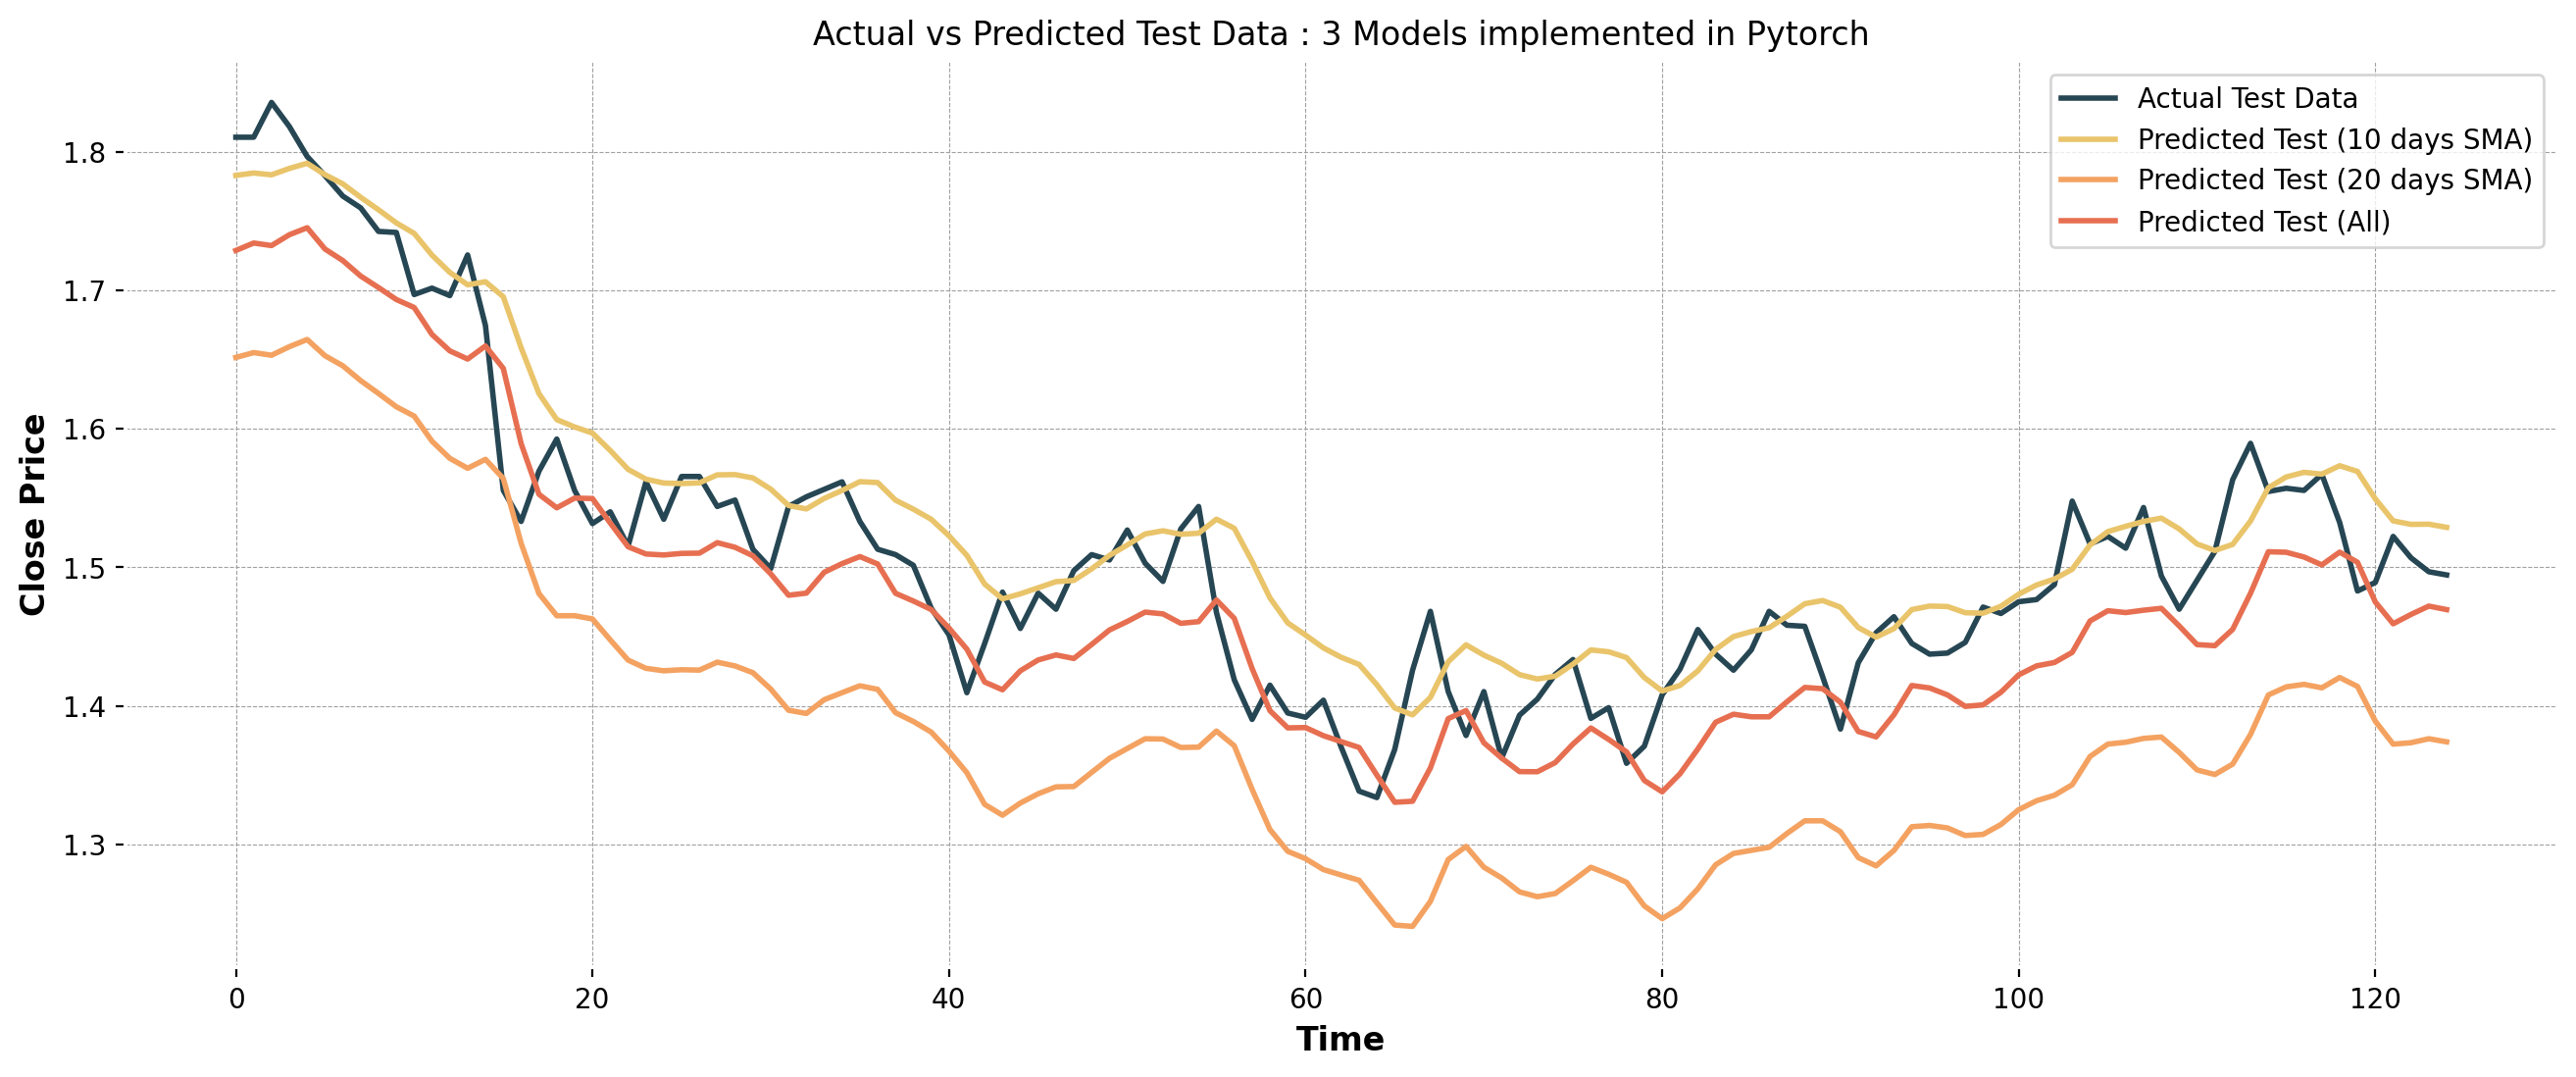

In [679]:
plt.figure(figsize=(16,6), dpi=200)
plt.plot(y_test_10d, label='Actual Test Data', color='#264653')
plt.plot(y_pred_10d, label='Predicted Test (10 days SMA)', color='#e9c46a')
plt.plot(y_pred_20d, label='Predicted Test (20 days SMA)', color='#f4a261')
plt.plot(y_pred_all, label='Predicted Test (All)', color='#e76f51')
plt.title('Actual vs Predicted Test Data : 3 Models implemented in Pytorch')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [680]:
# Get the last sequence of data as features for predicting the next 10 days
last_sequence = sequence_all[-1:, :, :]
last_sequence = torch.from_numpy(last_sequence).float()
# Generate predictions for the next 10 days
days_num = 10
with torch.no_grad():
    for i in range(days_num):
        pred = model_all(last_sequence)  # This should be of shape (1, 1, features)
        # Reshape pred to match the dimensions of last_sequence for concatenation
        pred = pred.unsqueeze(1)  # Add sequence length dimension (1, 1, features)
        last_sequence = torch.cat((last_sequence, pred), dim=1)  # Concatenate along sequence length
        last_sequence = last_sequence[:, 1:, :]  # Keep the last sequence length of data
# Convert predictions to numpy array
predicting_days = last_sequence.squeeze().numpy()
# Inverse transform the predicted values
predicting_days = scaler.inverse_transform(predicting_days)
# Extract relevant features (Open, High, Low, Close)
predicting_days = predicting_days[:days_num, :4]
# Create a DataFrame to store the predicted prices
df_pred = pd.DataFrame(
    data=predicting_days,
    columns=['Open', 'High', 'Low', 'Close']
)
# Get the last date in the main DataFrame
last_date_in_df = df['Date'].iloc[-1]
# Generate dates for the next 10 days after the last date in the main DataFrame
next_dates = pd.date_range(start=last_date_in_df + pd.Timedelta(days=1), periods=days_num)
# Create a DataFrame with the dates
df_dates = pd.DataFrame({'Date': next_dates})
# Concatenate the two DataFrames
df_combined = pd.concat([df_dates, df_pred], axis=1)
print(df_combined)

                       Date       Open       High        Low      Close
0 2025-01-09 00:00:00+03:00  41.900002  42.119999  41.639999  42.492001
1 2025-01-10 00:00:00+03:00  41.064075  40.984997  41.009270  41.033909
2 2025-01-11 00:00:00+03:00  40.266552  40.196835  40.217941  40.244011
3 2025-01-12 00:00:00+03:00  39.450111  39.381718  39.402775  39.426819
4 2025-01-13 00:00:00+03:00  38.652454  38.582970  38.604271  38.625820
5 2025-01-14 00:00:00+03:00  37.889671  37.818726  37.840336  37.859360
6 2025-01-15 00:00:00+03:00  37.164875  37.092705  37.114635  37.131237
7 2025-01-16 00:00:00+03:00  36.476170  36.403065  36.425316  36.439640
8 2025-01-17 00:00:00+03:00  35.820148  35.746338  35.768894  35.781109
9 2025-01-18 00:00:00+03:00  35.193287  35.118927  35.141773  35.152042
